In [1]:
from __future__ import print_function
import PIL
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 16})

from mpl_toolkits import mplot3d
from matplotlib.pyplot import text
from IPython.display import display, Math, Latex, Markdown
import os
from tqdm.notebook import tqdm
%matplotlib inline
%config InlineBackend.figure_format='retina'

import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform
from astroML import stats as astroMLstatsπ
from tqdm.notebook import tqdm
import random
import seaborn as sns

from scipy import stats, interpolate
from astropy.visualization import hist

from sklearn import datasets, preprocessing
from sklearn.manifold import Isomap
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture

# Fun with gamma ray bursts

## Import data and play

In [2]:
import requests

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])

In [3]:
T90=np.array(data[6],dtype=float)
print(T90)

[  48.641 -999.       2.56  ...    3.136  208.576    5.184]


In [4]:
df=pd.DataFrame(data=data[0:].T, columns=names[0:])
df

GRB_name GRB_name_Fermi            T0        ra      decl  pos_error  \
0     GRB230618B*   GRB230618227   5:26:11.930  257.5100   -6.6700   2.597466   
1      GRB230618A           None       3:51:12  196.6031    3.3035   0.000259   
2     GRB230617A*   GRB230617926  22:13:31.549  139.4500  -70.5300   9.277845   
3     GRB230614C*   GRB230614424  10:10:30.626  229.2100   10.3000   3.553469   
4     GRB230614B*   GRB230614385   9:15:01.627  110.9100  -61.8800   2.558593   
...           ...            ...           ...       ...       ...        ...   
8152  GRB910425B*           None   5:33:13.716  335.9500   25.7667   4.790000   
8153  GRB910425A*           None   0:37:45.700   91.3000  -22.7667   1.020000   
8154  GRB910424A*           None  19:43:25.064  201.3000  -45.4167  13.780000   
8155  GRB910423A*           None  19:51:15.804  193.4750   -8.3833  11.100000   
8156  GRB910421A*           None   9:14:03.800  270.6750   24.7667   0.530000   

           T90 T90_error     T90_start     fluence fluence_error redshift  \
0      48.6410    0.5720   5:26:13.466  2.3685e-05    4.7730e-08     -999   
1         -999      -999          -999        -999          -999     -999   
2       2.5600    1.4940  22:13:31.549  1.4248e-07    1.6109e-08     -999   
3       7.4240    0.5720  10:10:30.626  2.4026e-03    2.5744e-06     -999   
4      14.9090    0.6020   9:15:01.630  5.7082e-06    2.0192e-08     -999   
...        ...       ...           ...         ...           ...      ...   
8152  430.0160    1.0940   5:33:13.716  1.3510e-06    6.3429e-08     -999   
8153   90.1760    0.2860   0:37:49.924  1.3277e-05    6.8674e-08     -999   
8154    3.1360    0.5900  19:43:25.064  2.4858e-08    1.0496e-08     -999   
8155  208.5760    1.1180  19:51:15.804  1.6510e-07    1.7015e-08     -999   
8156    5.1840    0.1810   9:14:04.312  2.6055e-06    1.8857e-08     -999   

        'T100' GBM_located        mjd_(T0)  
0      50.1770        True  60113.22652697  
1         -999       False  60113.16055556  
2       2.5600        True  60112.92605959  
3       7.4240        True  60109.42396558  
4      14.9120        True  60109.38543550  
...        ...         ...             ...  
8152  430.0160       False  48371.23140875  
8153   94.4000       False  48371.02622338  
8154    3.1360       False  48370.82181787  
8155  208.5760       False  48369.82726625  
8156    5.6960       False  48367.38476620  

[8157 rows x 15 columns]

In [5]:
T90flux_unmasked = np.column_stack((df['T90'].astype(float),df['T90_error'].astype(float), df['fluence'].astype(float), df['fluence_error'].astype(float) ))
RA = df['ra']
DEC = df['decl']

In [6]:
T90flux_unmasked[:10]

array([[ 4.8641e+01,  5.7200e-01,  2.3685e-05,  4.7730e-08],
       [-9.9900e+02, -9.9900e+02, -9.9900e+02, -9.9900e+02],
       [ 2.5600e+00,  1.4940e+00,  1.4248e-07,  1.6109e-08],
       [ 7.4240e+00,  5.7200e-01,  2.4026e-03,  2.5744e-06],
       [ 1.4909e+01,  6.0200e-01,  5.7082e-06,  2.0192e-08],
       [ 2.4064e+01,  1.9500e+00,  2.9822e-06,  4.2925e-08],
       [ 1.7408e+01,  7.2400e-01,  4.5713e-06,  3.6677e-08],
       [ 1.5872e+01,  5.1840e+00,  8.5521e-07,  5.3646e-08],
       [ 1.5616e+01,  9.2300e-01,  1.8231e-06,  3.0509e-08],
       [ 2.0480e+01,  3.6200e+00,  3.5151e-06,  5.8725e-08]])

##### Check for data that have null flux

In [7]:
T90_flux_null=T90flux_unmasked[(T90flux_unmasked[:,0] != -999) & (T90flux_unmasked[:,1] != -999) & (T90flux_unmasked[:,2] != -999) & (T90flux_unmasked[:,3] != -999) ]
T90_flux_null[(T90_flux_null[:,2]==0.0e+00),0]

array([1.89700e+00, 4.48000e-01, 1.66400e+00, 7.68000e-01, 2.08000e-01,
       4.90000e-01, 5.60000e-02, 4.48000e-01, 2.36800e+00, 6.40000e-02,
       1.36000e-01, 4.54400e+00, 6.40000e-01, 1.76000e-01, 1.19872e+02,
       3.20960e+01, 2.56000e-01, 1.95300e+00, 6.36000e-01, 6.33920e+01,
       1.28000e-01, 2.56000e-01, 2.24000e+00, 6.40000e-01, 1.11200e+00,
       1.28000e-01, 1.21600e+00, 1.83000e-01])

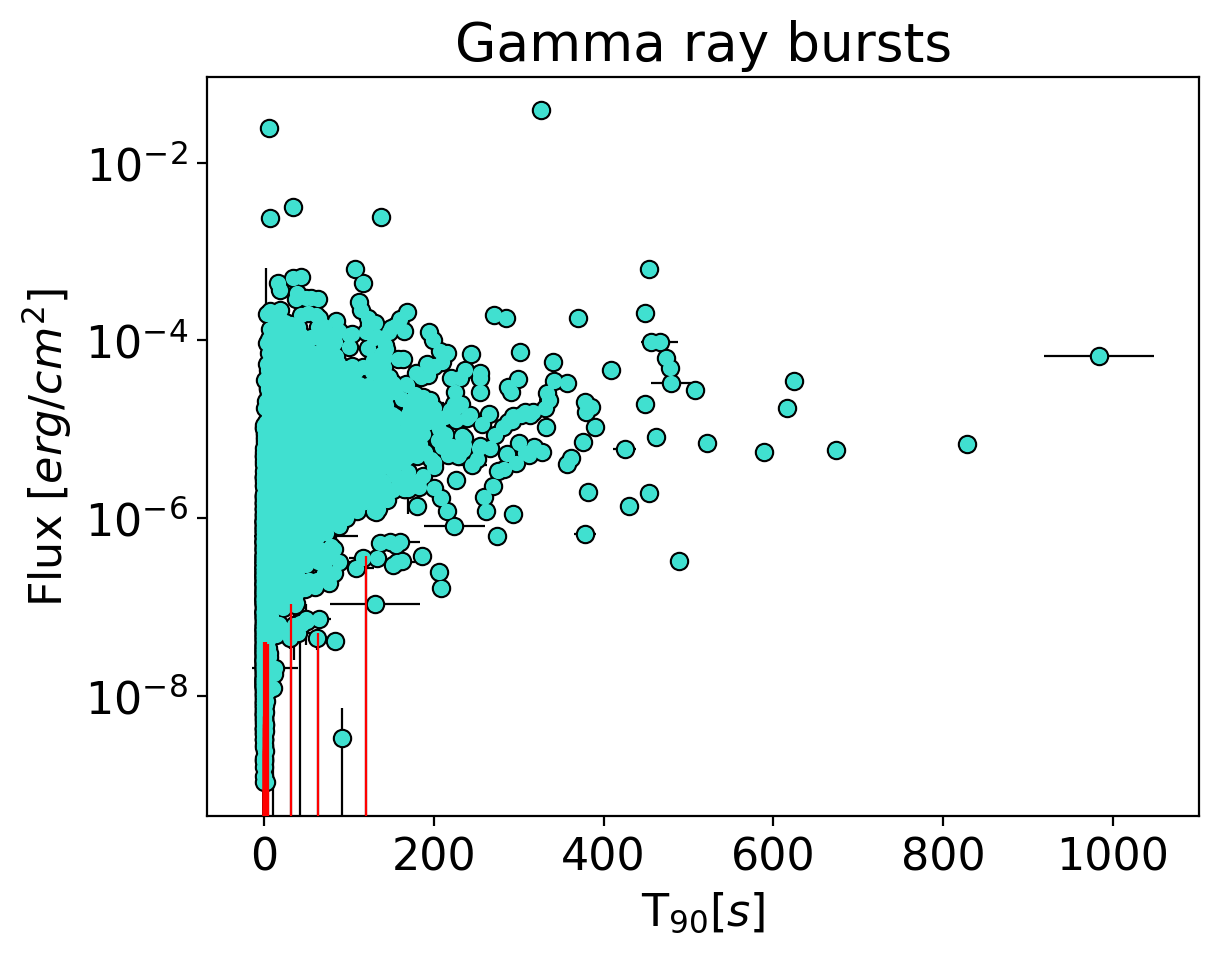

In [8]:
plt.scatter(T90_flux_null[:,0],T90_flux_null[:,2], color='turquoise',s=20,alpha=1,edgecolors='turquoise', zorder=1)
plt.errorbar(T90_flux_null[:,0],T90_flux_null[:,2], xerr=T90_flux_null[:,1],yerr=T90_flux_null[:,3], fmt="o", ms=6, 
             mec="black", ecolor='black', mfc='turquoise', elinewidth=0.8, label='data', zorder=0)
plt.errorbar(T90_flux_null[T90_flux_null[:,2]==0.0e+00,0],T90_flux_null[T90_flux_null[:,2]==0.0e+00,2], 
             xerr=T90_flux_null[T90_flux_null[:,2]==0.0e+00,1],yerr=T90_flux_null[T90_flux_null[:,2]==0.0e+00,3],
             fmt="o", ms=6, mec="red", ecolor='red', mfc='red', elinewidth=0.8,zorder=3)
#plt.semilogx()
plt.semilogy()
#plt.xlim(-5,15)
#plt.ylim(-0.0005,0.0005)
plt.xlabel("T$_{90} [s]$")
plt.ylabel("Flux $[erg/cm^2]$")
plt.title("Gamma ray bursts")
plt.show()

##### Filter also data that have null flux

In [9]:
#filter data with '-999' and for flux '0.0e+00'
T90_flux=T90flux_unmasked[(T90flux_unmasked[:,0] != -999) & (T90flux_unmasked[:,1] != -999) & (T90flux_unmasked[:,2] != -999) & (T90flux_unmasked[:,3] != -999) & (T90flux_unmasked[:,2] != 0.0e+00) ]
len(T90_flux)

6008

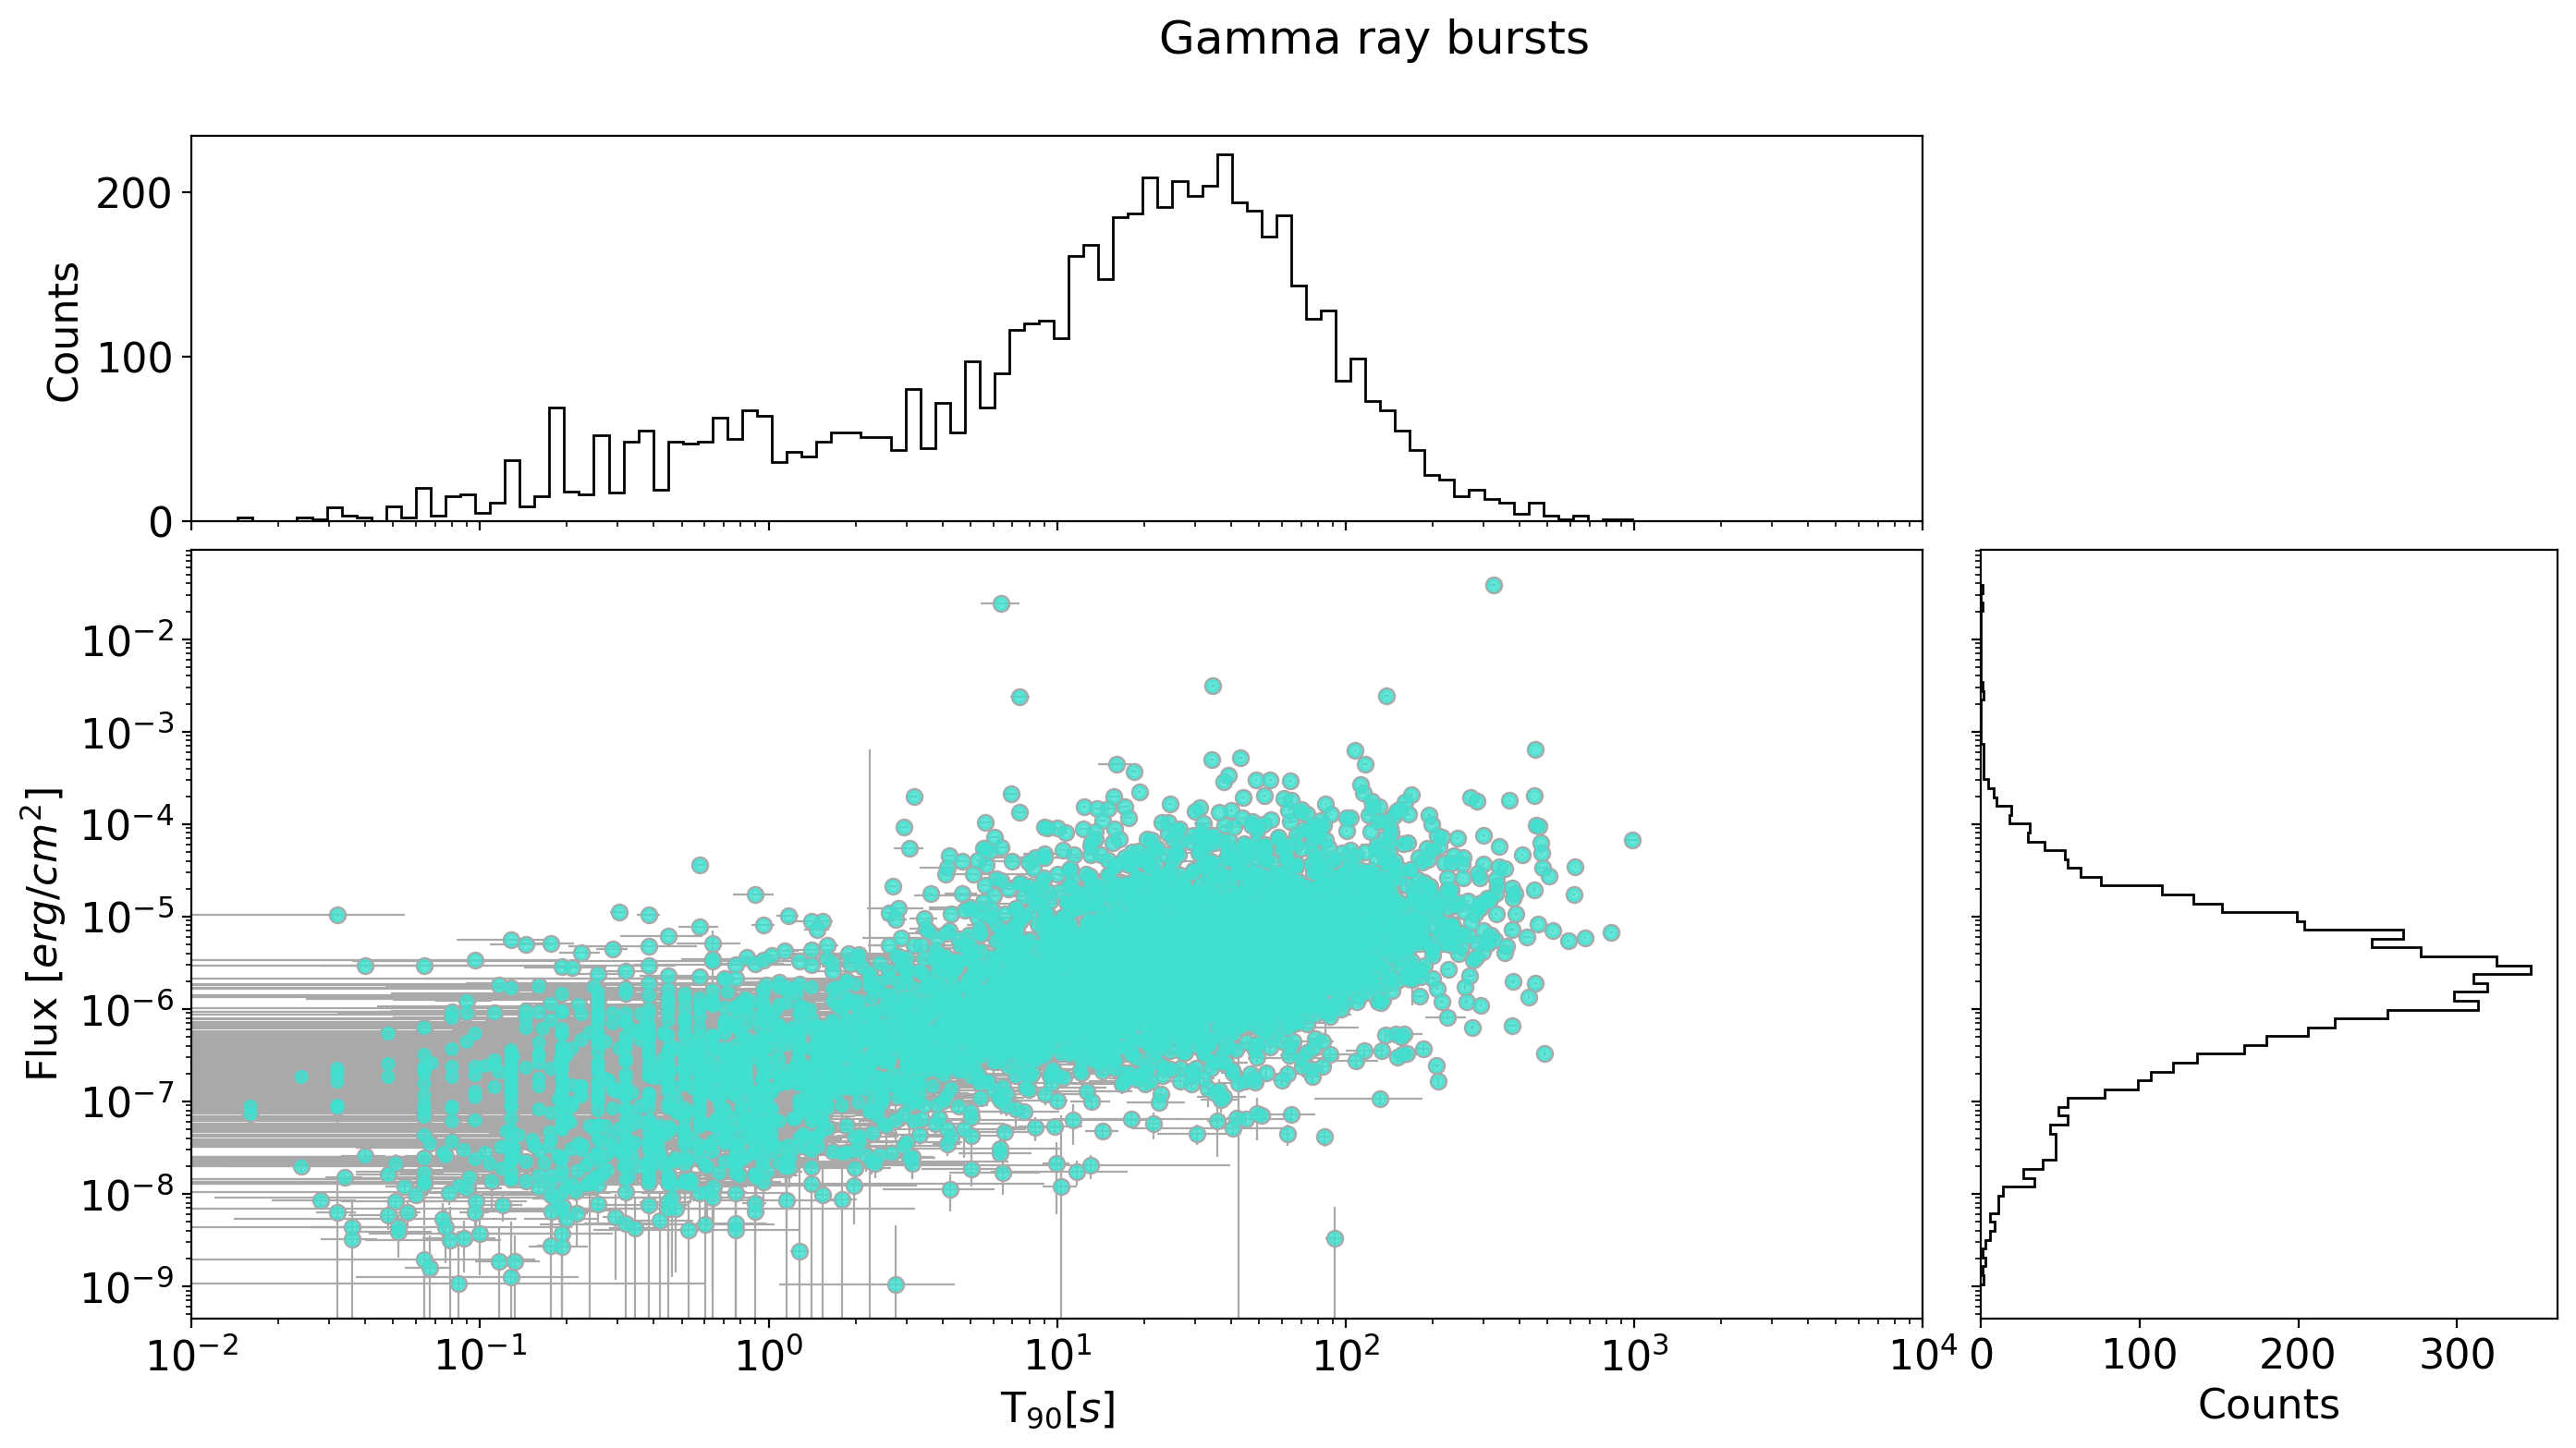

In [10]:
#plt.rcParams.update({'font.size': 16})

def scatter_hist(x, y, x_err, y_err, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    ax.scatter(x,y, color='turquoise',s=20,alpha=0.8,edgecolors='turquoise', zorder=1)
    ax.errorbar(x,y, xerr=x_err,yerr=y_err, fmt="o", ms=6, mec="darkgray", ecolor='darkgray', 
                mfc="none", elinewidth=0.8, label='data', zorder=0)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel("T$_{90} [s]$")
    ax.set_ylabel("Flux $[erg/cm^2]$")
    ax.set_xlim(10e-3,10e3)

    #histograms
    ax_histx.hist(x, bins=np.logspace(np.log10(min(T90_flux[:,0])),np.log10(max(T90_flux[:,0])),100),
                  histtype='step',color='k')
    ax_histx.set_ylabel("Counts")
    ax_histy.hist(y, bins=np.logspace(np.log10(min(T90_flux[:,2])),np.log10(max(T90_flux[:,2])),80), 
                  orientation='horizontal',histtype='step',color='k')
    ax_histy.set_xlabel("Counts")

# Final plot
fig = plt.figure(figsize=(16, 8))
fig.suptitle('Gamma ray bursts', fontsize=18)

# Add a gridspec with two rows and two columns 
# Also adjust the subplot parameters for a square plot
gs = fig.add_gridspec(2, 2,  width_ratios=(3, 1), height_ratios=(2, 4),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.05)

# Create the Axes
ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

# Draw the scatter plot and marginals
scatter_hist(T90_flux[:,0],T90_flux[:,2], T90_flux[:,1],T90_flux[:,3], ax, ax_histx, ax_histy)

In [11]:
T90fluxz_unmasked = np.column_stack((df['T90'].astype(float),df['T90_error'].astype(float), df['fluence'].astype(float), df['fluence_error'].astype(float), df['redshift'].astype(float) ))
T90fluxz = T90fluxz_unmasked[ (T90fluxz_unmasked[:,0] > 0) & (T90fluxz_unmasked[:,1] > 0) & (T90fluxz_unmasked[:,2] > 0) & (T90fluxz_unmasked[:,3] > 0) & (T90fluxz_unmasked[:,4] > 0) ]

## Unsupervised classification: clustering

In [12]:
X = T90_flux[:,::2]
X_err = T90_flux[:,1::2]
print(X.shape, X_err.shape)

(6008, 2) (6008, 2)


In [13]:
#split unlabeled dataset

X_train, X_test, X_err_train, X_err_test  = train_test_split(np.log(X), X_err, test_size=0.20, random_state=42)
print(X_train.shape, X_err_train.shape, X_train.shape[0]/X.shape[0])
print(X_err_train)

(4806, 2) (4806, 2) 0.7999334221038615
[[4.8340e+00 2.8629e-08]
 [1.2237e+01 5.3940e-07]
 [1.6000e+00 2.1000e-07]
 ...
 [1.0940e+00 3.5455e-08]
 [2.3100e-01 5.3571e-09]
 [9.2300e-01 1.5918e-08]]


### K-means clustering: number of clusters known

In [14]:
n_clusters = 2
k_means_wo = KMeans(n_clusters=n_clusters)
k_means_wo.fit(X_train)
class_pred_wo = k_means_wo.predict(X_train)
centers_wo = k_means_wo.cluster_centers_ #location of the clusters
centers_wo

/home/olga/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17a3575700>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17a3d97700>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


array([[  3.4167798 , -12.48488667],
       [  0.01715531, -15.53145513]])

###### about weights: 
weight need to be 1D or scalar...but I have 2 features so 2D (?)\
-> try to sum them up in quadrature! (or maybe try with MCMC)

In [15]:
sumq_errors = np.log(X_err_train[:,0])**2 + np.log(X_err_train[:,1])**2 
sample_weight =  1/sumq_errors
sample_weight                            

array([0.00328775, 0.0046603 , 0.0042257 , ..., 0.00339787, 0.00274083,
       0.00310157])

In [16]:
k_means = KMeans(n_clusters=n_clusters)
k_means.fit(X_train, sample_weight=sample_weight)
class_pred = k_means.predict(X_train, sample_weight=sample_weight)
centers = k_means.cluster_centers_ #location of the clusters
centers

/home/olga/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17a3d97d30>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17a3d97d30>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


array([[  0.24069827, -15.33782659],
       [  3.47710426, -12.35281885]])

/tmp/ipykernel_19681/2726179941.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)


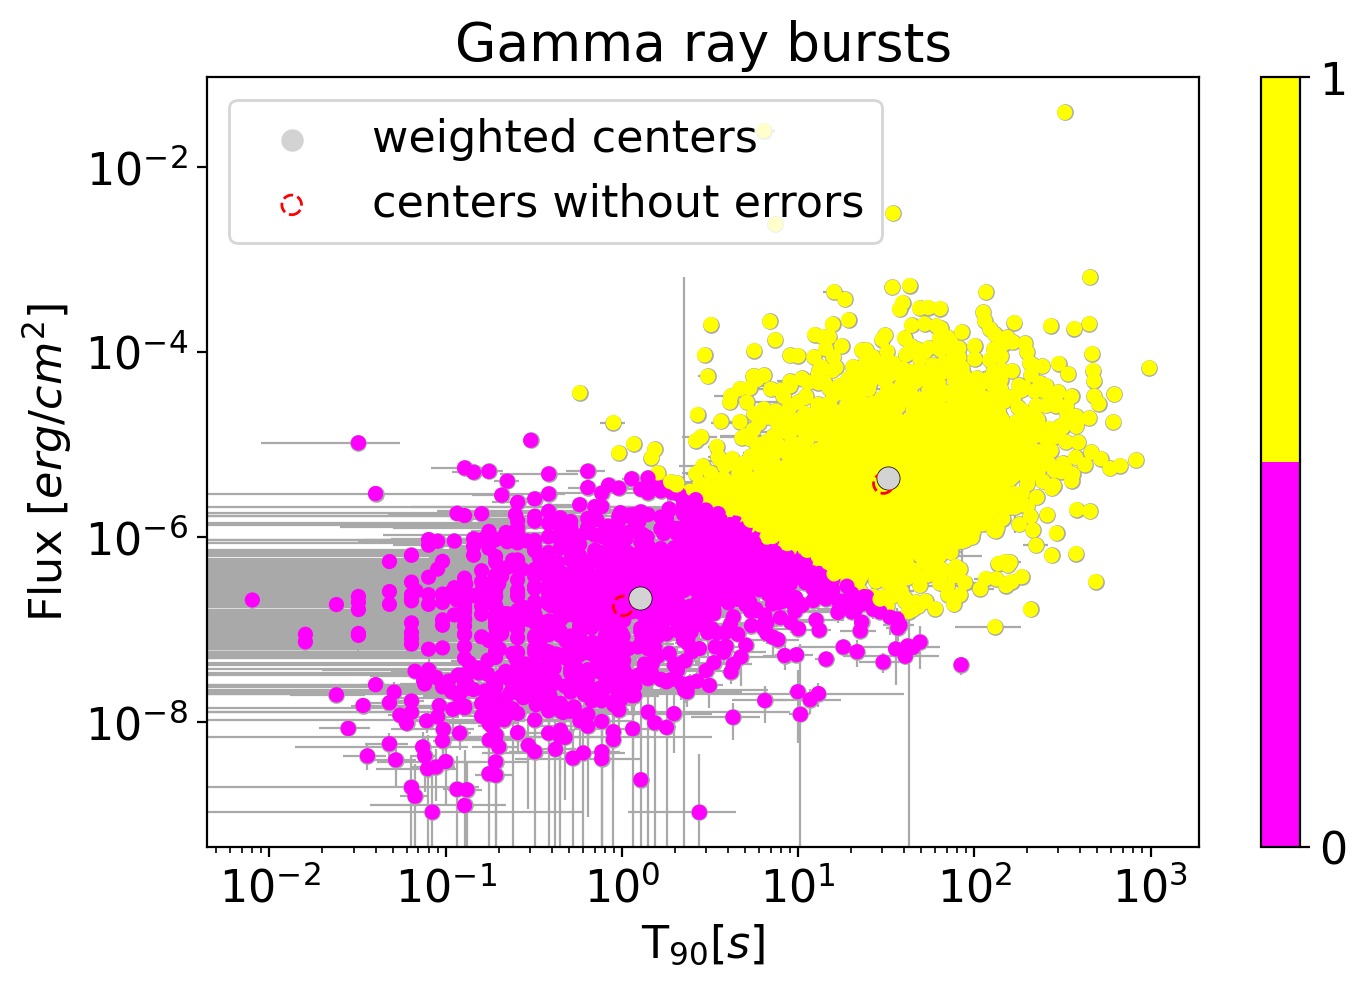

In [17]:
#plot results

plt.figure(figsize=(8, 5))
sctt = plt.scatter(np.exp(X_train[:, 0]), np.exp(X_train[:, 1]), s=20, c=class_pred, 
                   cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)
plt.errorbar(np.exp(X_train[:, 0]),np.exp(X_train[:, 1]), xerr=X_err_train[:, 0],yerr=X_err_train[:, 1], fmt="o", 
             ms=5, mec="darkgray", ecolor='darkgray', mfc="darkgray", elinewidth=0.8, zorder=0)
plt.scatter(np.exp(centers[:,0]), np.exp(centers[:,1]),s=50,c='lightgray', zorder=3, label='weighted centers ')
plt.scatter(np.exp(centers[:,0]), np.exp(centers[:,1]),s=58,c='k', zorder=2)
plt.scatter(np.exp(centers_wo[:,0]), np.exp(centers_wo[:,1]),s=50,facecolors='none', edgecolors='r',
            linestyle='--', zorder=2, label='centers without errors')
plt.colorbar(sctt,ticks=np.arange(n_clusters))
plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel("T$_{90} [s]$")
plt.ylabel("Flux $[erg/cm^2]$")
plt.title("Gamma ray bursts")
plt.show()

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f178c488e50>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

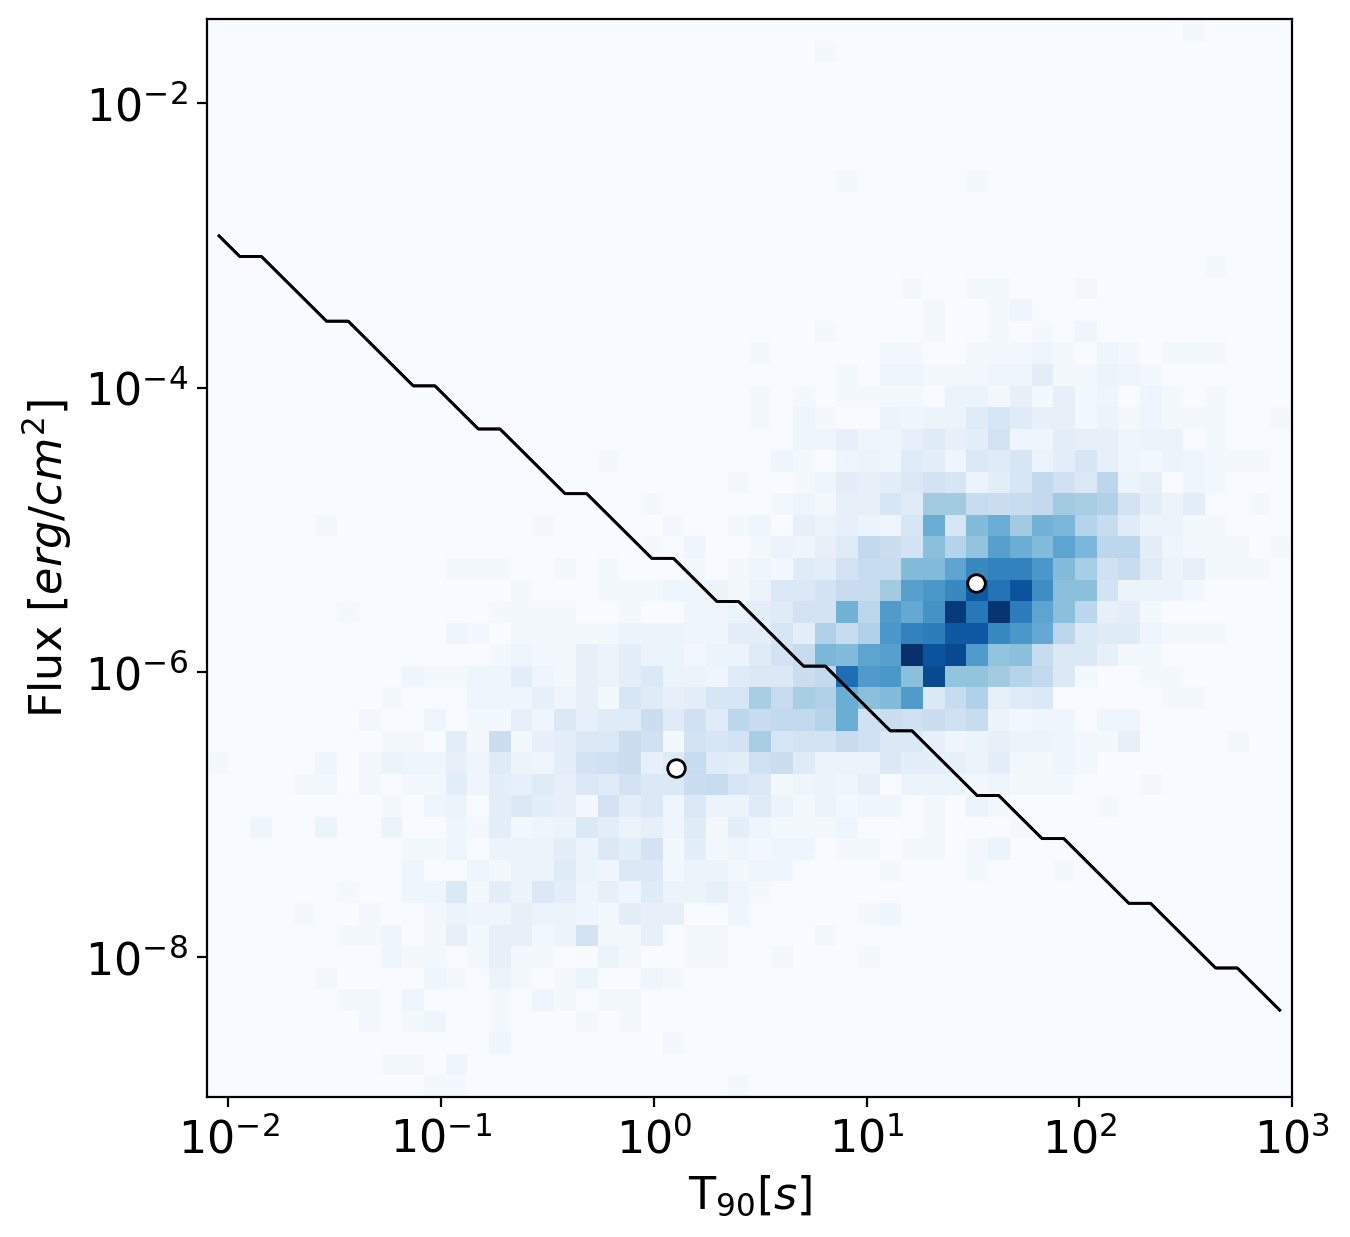

In [18]:
# Make some plots
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = k_means.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = k_means.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()

###### Test the clustering

In [19]:
sumq_errors_test = np.log(X_err_test[:,0])**2 + np.log(X_err_test[:,1])**2 
sample_weight_test =  1/sumq_errors_test
sample_weight_test
test_pred = k_means.predict(X_test, sample_weight = sample_weight_test)
test_pred

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f178c4ab700>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


array([1, 0, 0, ..., 1, 0, 1], dtype=int32)

/tmp/ipykernel_19681/2345124361.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


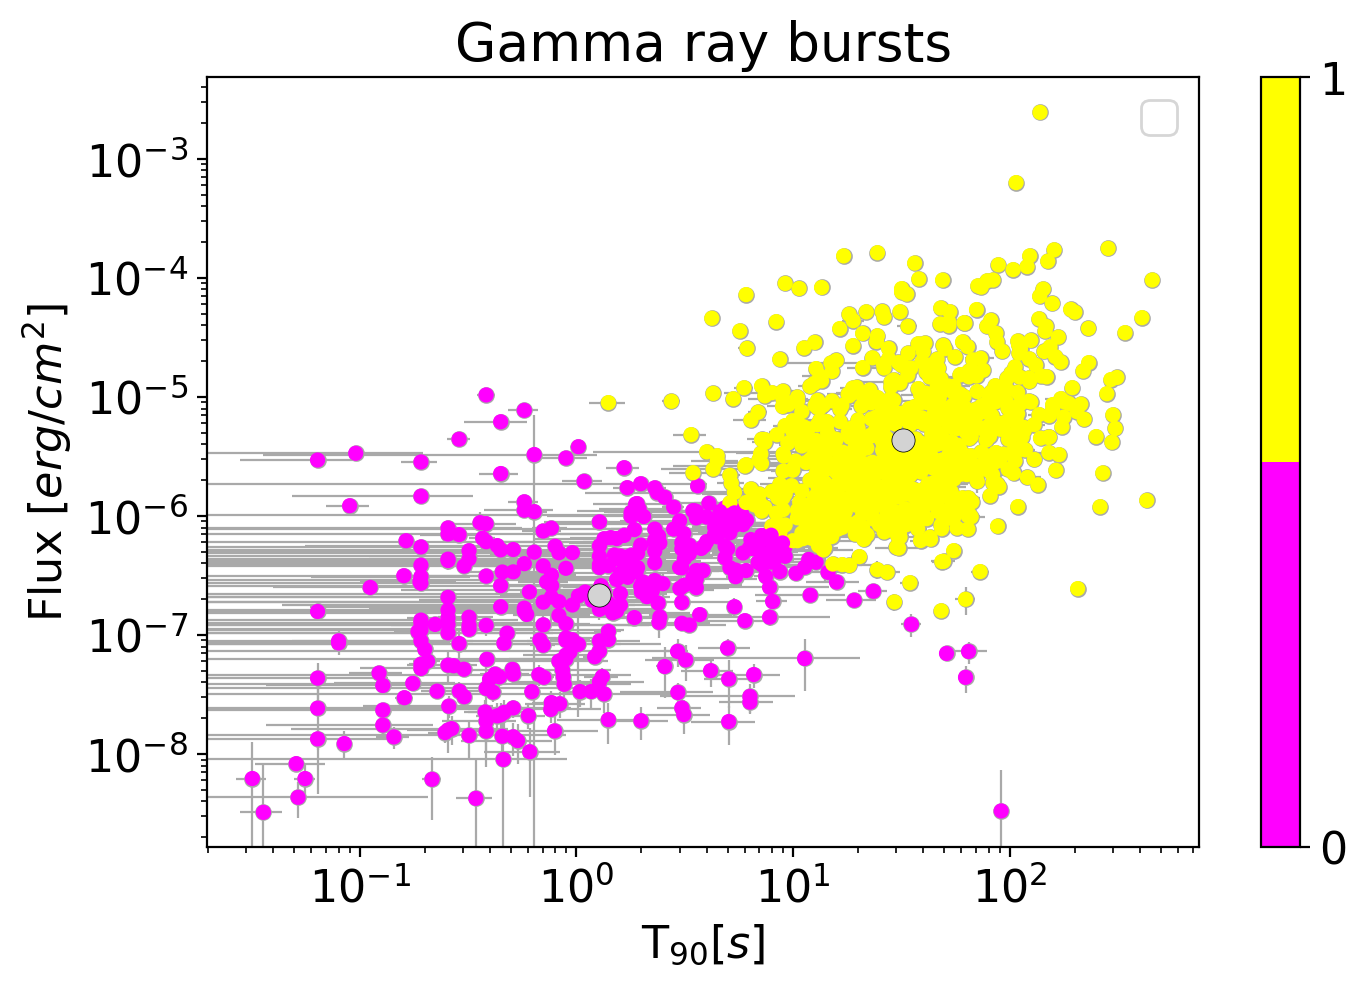

In [20]:
#plot results

plt.figure(figsize=(8, 5))
sctt = plt.scatter(np.exp(X_test[:, 0]), np.exp(X_test[:, 1]), s=20, c=test_pred, 
                   cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)
plt.errorbar(np.exp(X_test[:, 0]),np.exp(X_test[:, 1]), xerr=X_err_test[:, 0],yerr=X_err_test[:, 1], 
             fmt="o", ms=5, mec="darkgray", ecolor='darkgray', mfc="darkgray", elinewidth=0.8, zorder=0)
plt.scatter(np.exp(centers[:,0]), np.exp(centers[:,1]),s=50,c='lightgray', zorder=3)
plt.scatter(np.exp(centers[:,0]), np.exp(centers[:,1]),s=58,c='k', zorder=2)
plt.colorbar(sctt,ticks=np.arange(n_clusters))
plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel("T$_{90} [s]$")
plt.ylabel("Flux $[erg/cm^2]$")
plt.title("Gamma ray bursts")
plt.show()

## Gaussian mixture: how many types of GRBs?

Let's see through a gaussian mixture & AIC study, which are the best-fit of the two distribution and hence how many types of gamma ray bursts do we have

In [21]:
grb_time = np.log10(T90_flux[:,0])
grb_flux = np.log10(T90_flux[:,2])

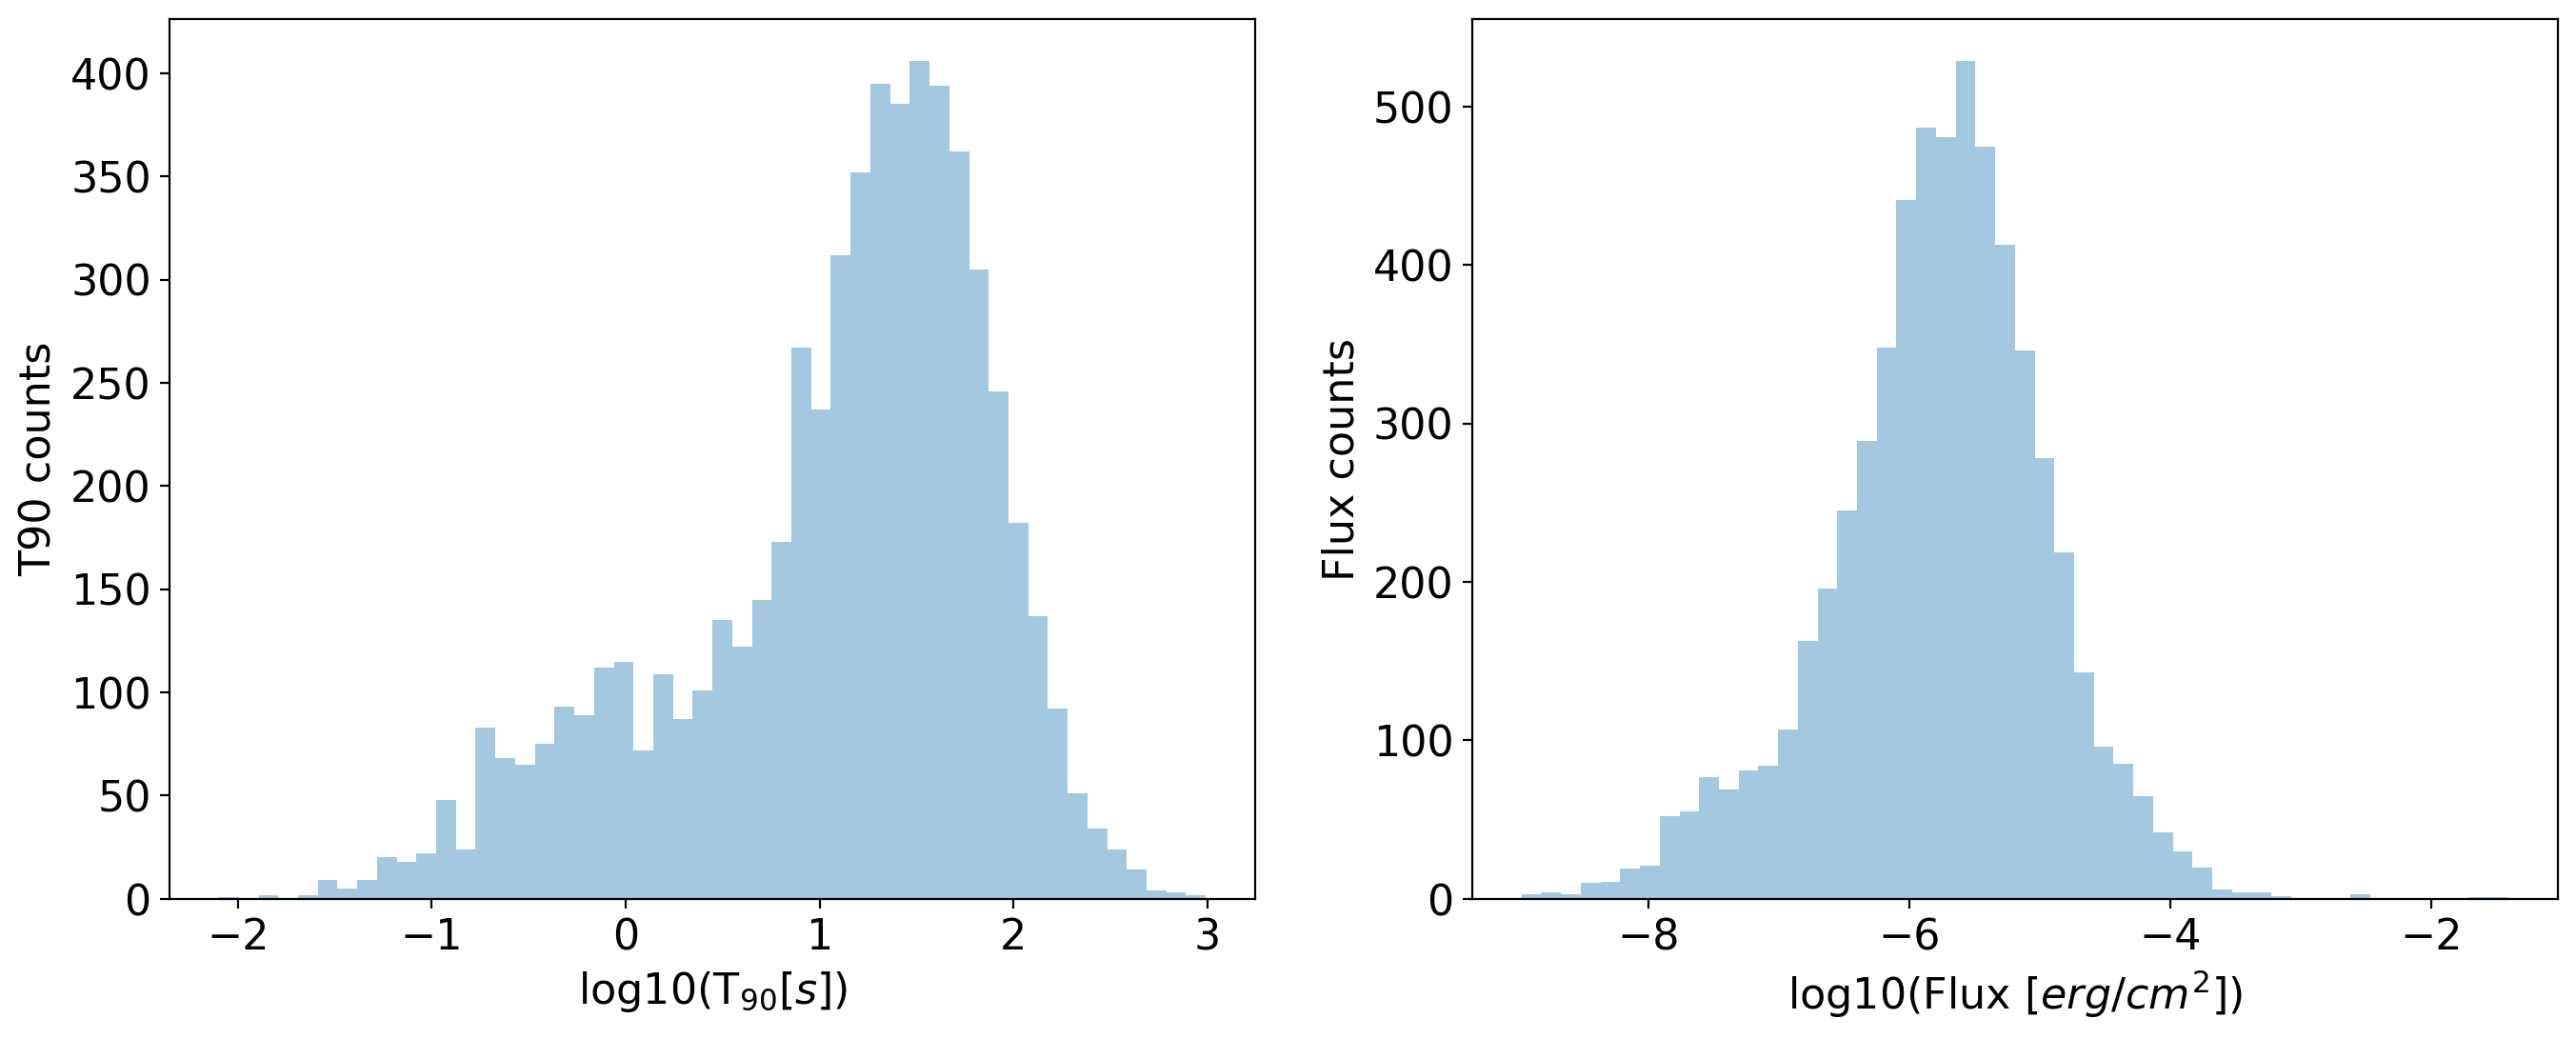

In [22]:
fig = plt.figure(figsize=(25, 6))
#fig.subplots_adjust(left=0.12, right=0.97, bottom=0.21, top=0.9, wspace=0.5)

ax = fig.add_subplot(131)
ax.hist(grb_time, bins=50, density=False, histtype='stepfilled', alpha=0.4)
ax.set_xlabel("log10(T$_{90} [s])$")
ax.set_ylabel('T90 counts')
#ax.set_xlim(10e-3,10e3)


ax = fig.add_subplot(132)
ax.hist(grb_flux, bins=50, density=False, histtype='stepfilled', alpha=0.4)
ax.set_xlabel("log10(Flux $[erg/cm^2]$)")
ax.set_ylabel('Flux counts')
#ax.set_xlim(10e-10,10e-3)


plt.show()

In [23]:
N = np.arange(1,5)
aic_val_f = []
aic_val_t = []
models_f = [None for i in range(len(N))]
models_t = [None for i in range(len(N))]

for i in range(1,len(N)+1):
    gm_t = GaussianMixture(n_components=i)#, random_state=0)       #NEED TO BE DIFFERENT MODELS!!
    gm_f = GaussianMixture(n_components=i)
    models_t[i-1] = gm_t.fit(grb_time[:,np.newaxis])
    models_f[i-1] = gm_f.fit(grb_flux[:,np.newaxis])
    
    aic_val_t.append(gm_t.aic(grb_time[:,np.newaxis]))
    aic_val_f.append(gm_f.aic(grb_flux[:,np.newaxis]))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f178c463790>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

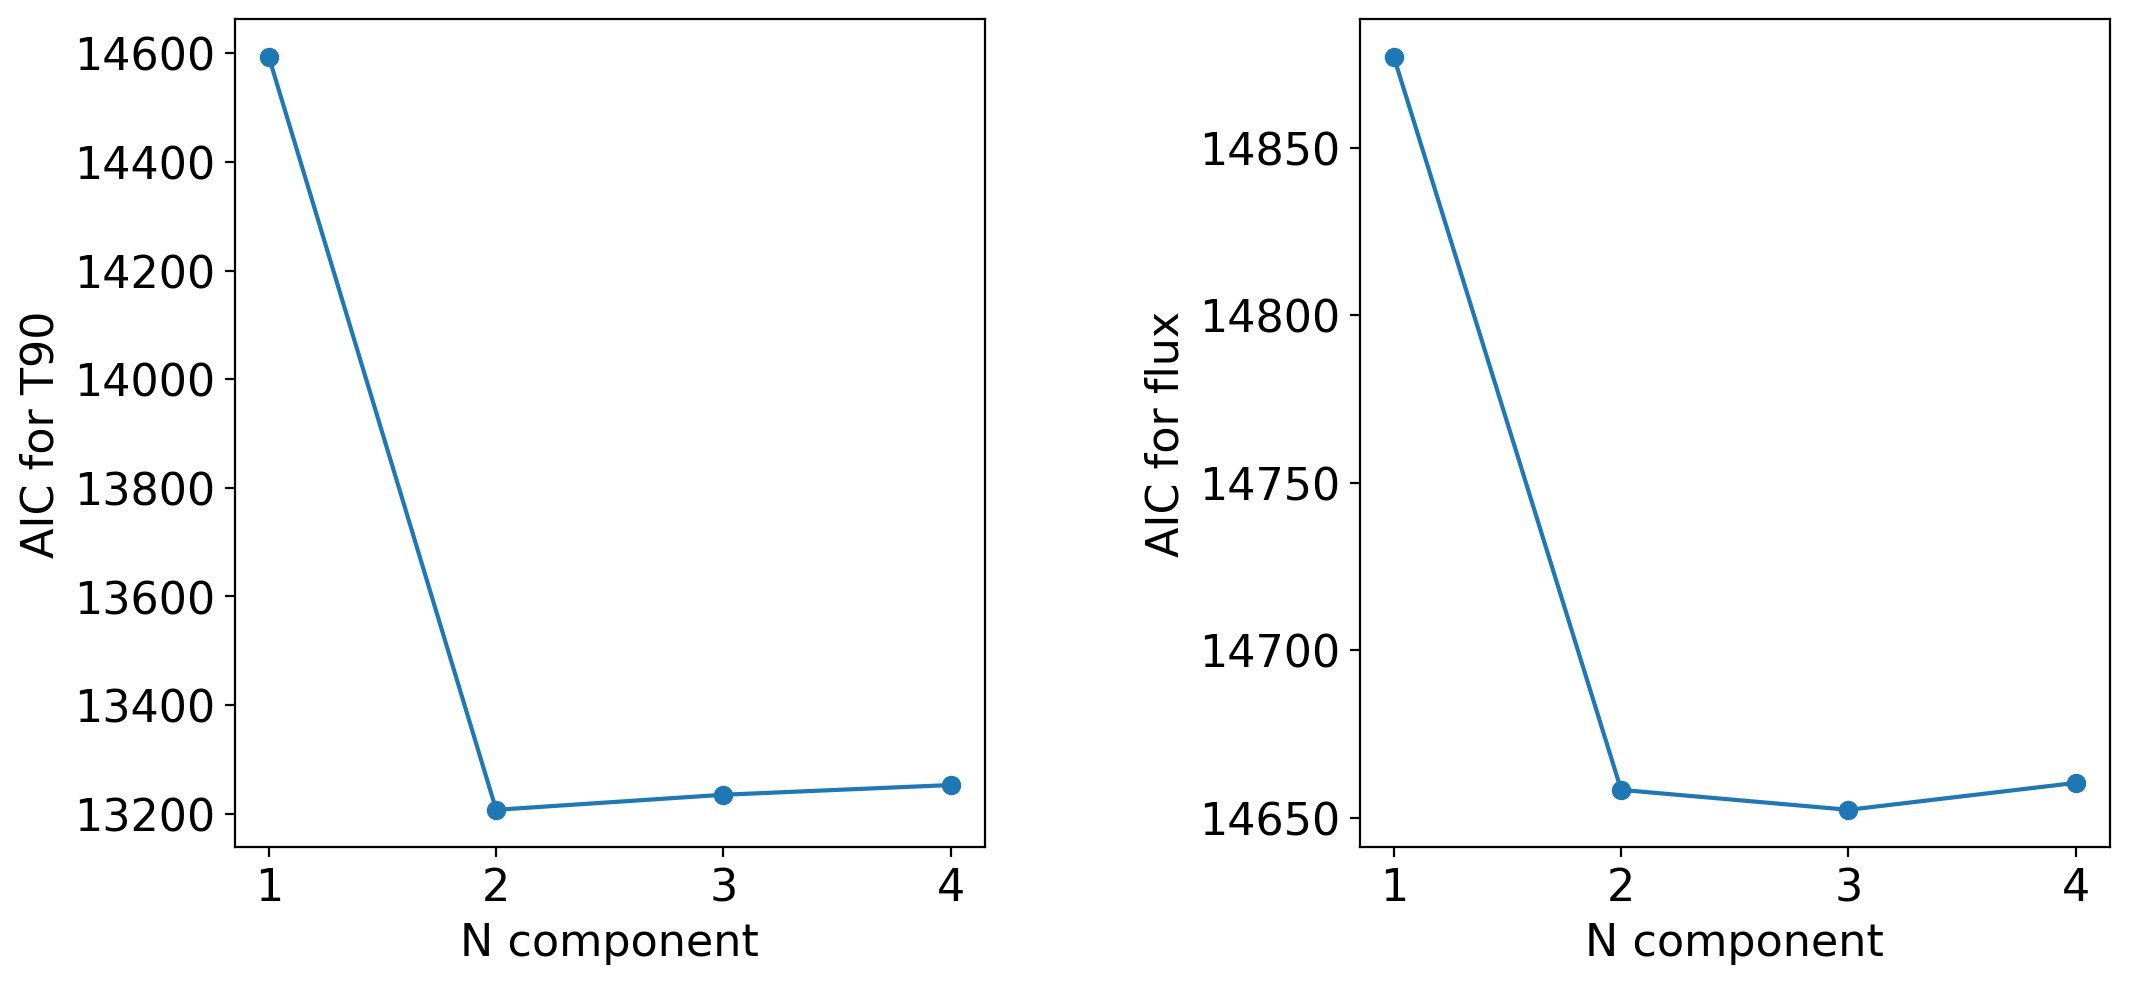

In [24]:
fig = plt.figure(figsize=(25, 6))
fig.subplots_adjust(left=0.1, right=0.7, bottom=0.21, top=0.9, wspace=0.5)

ax = fig.add_subplot(131)
ax.plot(N, aic_val_t)
ax.scatter(N, aic_val_t)
ax.set_xlabel("N component")
ax.set_ylabel("AIC for T90")
ax.set_xticks(np.arange(min(N), max(N)+1, 1))

ax = fig.add_subplot(132)
ax.plot(N, aic_val_f)
ax.scatter(N, aic_val_f)
ax.set_xlabel("N component")
ax.set_ylabel("AIC for flux")
ax.set_xticks(np.arange(min(N), max(N)+1, 1))


plt.show()

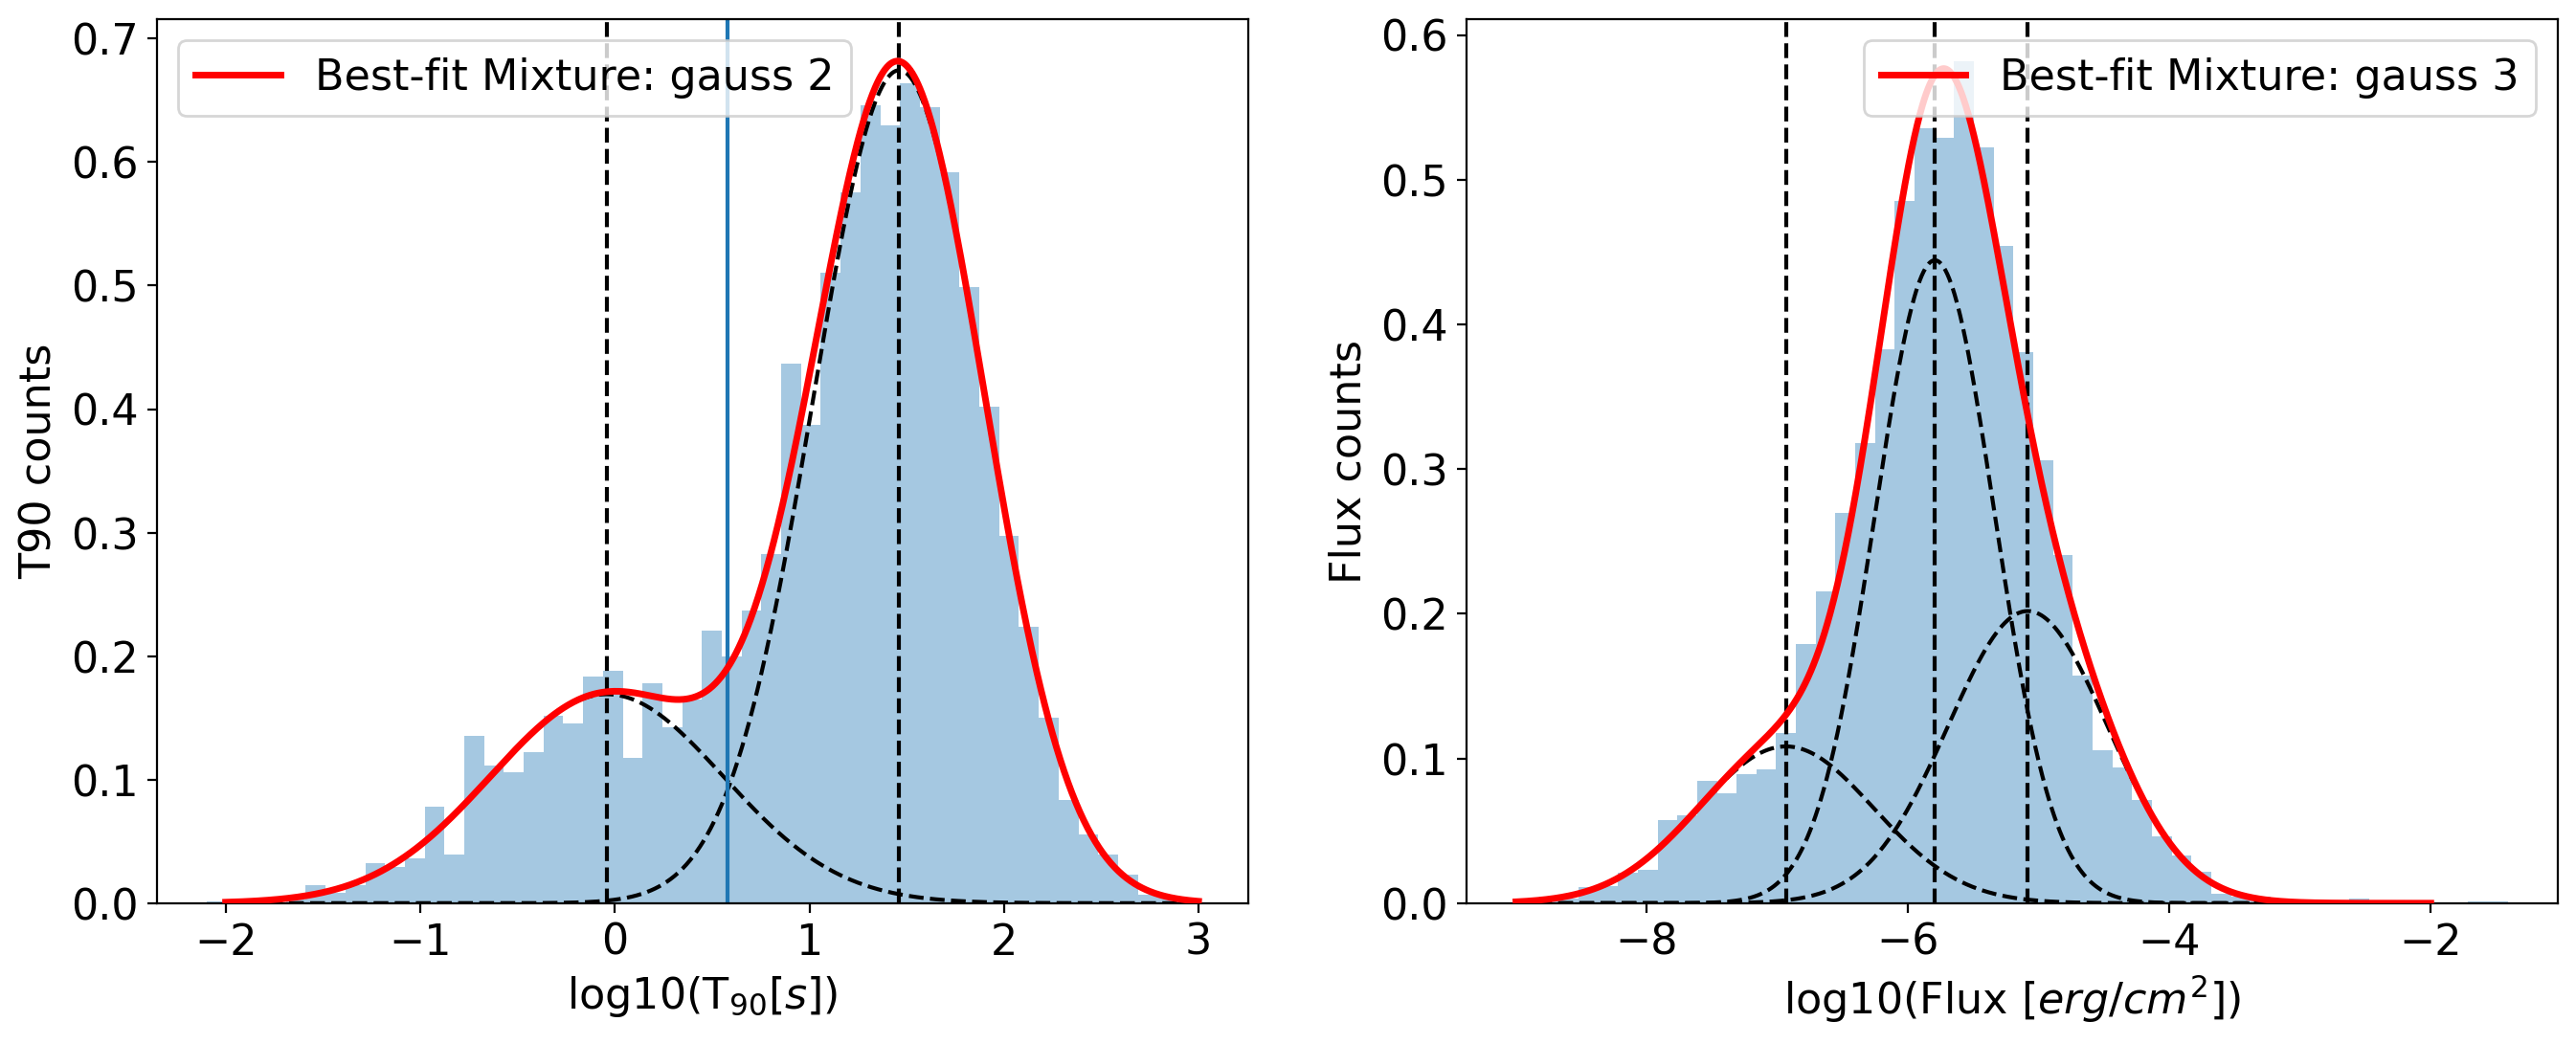

In [25]:
fig = plt.figure(figsize=(25, 6))
#fig.subplots_adjust(left=0.12, right=0.97, bottom=0.21, top=0.9, wspace=0.5)

ax = fig.add_subplot(131)
M_best_t = models_t[np.argmin(aic_val_t)]

x_t = np.linspace(-2, 3, 1000)
logprob_t = M_best_t.score_samples(x_t.reshape(-1, 1))
responsibilities_t = M_best_t.predict_proba(x_t.reshape(-1, 1))     #percentage of contribution respect to the total
means_t = (M_best_t.means_)
pdf_t = np.exp(logprob_t)
pdf_individual_t = responsibilities_t * pdf_t[:, np.newaxis]

ax.hist(grb_time, 50, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x_t, pdf_t, 'r',linewidth=2.5, label="Best-fit Mixture: gauss "+str(np.argmin(aic_val_t)+1),zorder=3)
ax.plot(x_t, pdf_individual_t, '--k')
for t in means_t:
    ax.axvline(t, color='k',linestyle='dashed')
ax.axvline(0.58)
ax.set_xlabel("log10(T$_{90} [s])$")
ax.set_ylabel('T90 counts')
ax.legend(loc='upper left')

ax = fig.add_subplot(132)
M_best_f = models_f[np.argmin(aic_val_f)]

x_f = np.linspace(-9, -2, 1000)
logprob_f = M_best_f.score_samples(x_f.reshape(-1, 1))
responsibilities_f = M_best_f.predict_proba(x_f.reshape(-1, 1))     #percentage of contribution respect to the total
means_f = (M_best_f.means_)
pdf_f = np.exp(logprob_f)
pdf_individual_f = responsibilities_f * pdf_f[:, np.newaxis]

ax.hist(grb_flux, 50, density=True, histtype='stepfilled', alpha=0.4)
ax.plot(x_f, pdf_f, 'r',linewidth=2.5, label="Best-fit Mixture: gauss "+str(np.argmin(aic_val_f)+1),zorder=3)
ax.plot(x_f, pdf_individual_f, '--k')
for f in means_f:
    ax.axvline(f, color='k',linestyle='dashed')
ax.set_xlabel("log10(Flux $[erg/cm^2]$)")
ax.set_ylabel('Flux counts')
ax.legend(loc='upper right')

plt.show()

In [26]:
print("Long and short GRBs separation happens at = ",10**(0.58),"s")

Long and short GRBs separation happens at =  3.8018939632056115 s


## wait!
The results are even more confusing! How is it possible that from time distribution we get 2 components (meaning 2 types of GRBs) and from flux we get 3?

Let's perform a Bayesian Information Criterion analysis on the models ($M_1 = \text{2 gaussians and } M_2 = \text{3 gaussian}$) in order to understand more about that inconsistency:

$$ BIC = -2  \ln(L_0(M)) +k\ln(N)$$

where $k$ are model parameters and N the data in your model. As AIC also BIC has to be minimized $\rightarrow$ the second term highly penalize complex models!

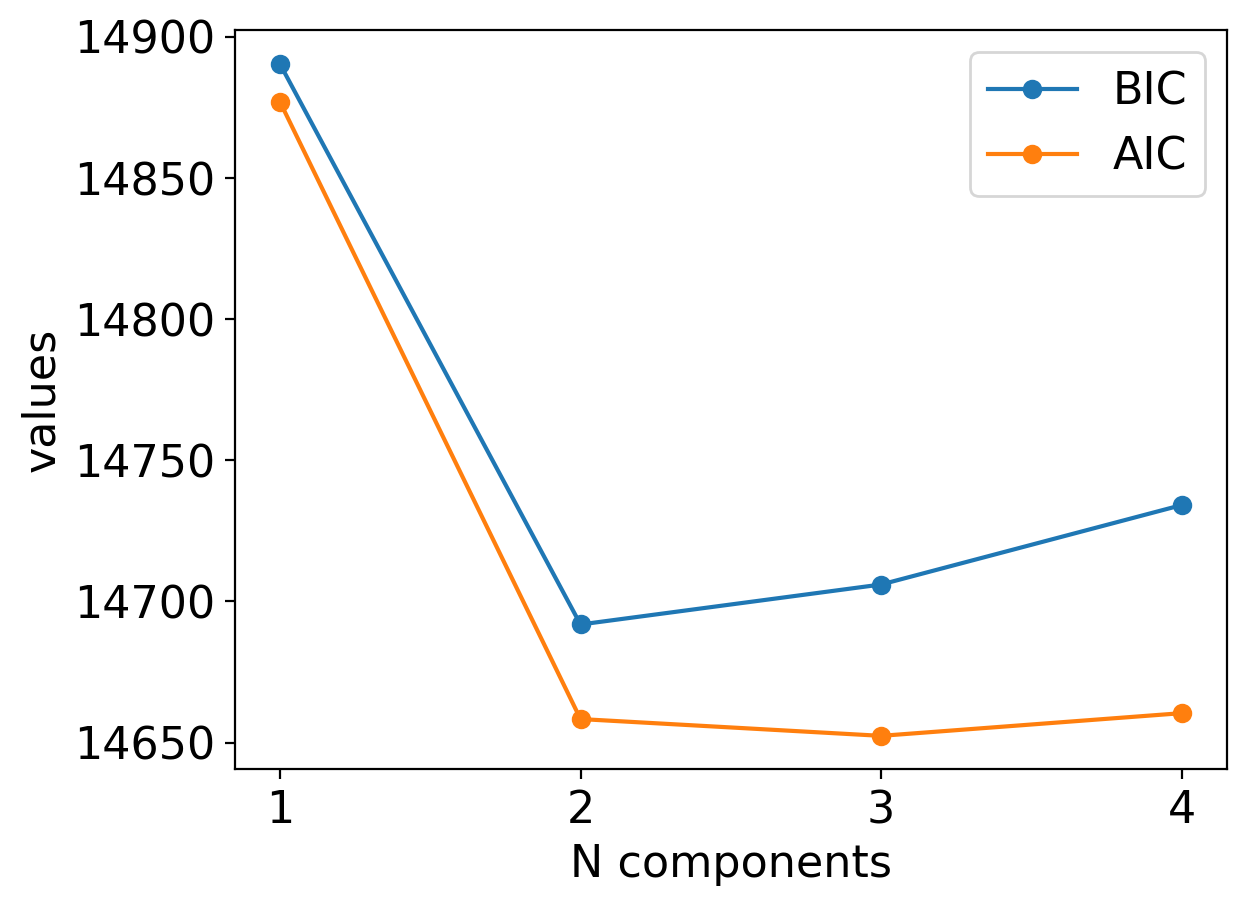

In [27]:
BICf_i = np.zeros(len(N))
AICf_i = np.zeros(len(N))

for i in N-1:
    BICf_i[i] = (models_f[i]).bic(grb_flux[:,np.newaxis])
    AICf_i[i] = (models_f[i]).aic(grb_flux[:,np.newaxis])
    
plt.plot(N, BICf_i, '-o', label='BIC')
plt.plot(N, AICf_i, '-o', label='AIC')
plt.xlabel("N components")
plt.ylabel('values')
plt.xticks(np.arange(min(N), max(N)+1, 1))
plt.legend()
plt.show()

In [28]:
BICt_3 = (models_t[np.argmin(aic_val_t)]).bic(grb_time[:,np.newaxis])
BICt_2 = (models_t[2]).bic(grb_time[:,np.newaxis])
print(BICt_3, BICt_2)

BICf_3 = (models_f[np.argmin(aic_val_f)]).bic(grb_flux[:,np.newaxis])
BICf_2 = (models_f[np.argmin(BICf_i)]).bic(grb_flux[:,np.newaxis])
if BICf_i[1] < BICf_i[2] : print("That's what we wanted! : flux has 2 comp (",BICf_i[1],") and not 3 (",BICf_i[2],")" )

13240.746514307453 13288.57336351083
That's what we wanted! : flux has 2 comp ( 14691.852765308298 ) and not 3 ( 14706.008382840851 )


### Mean-shift clustering: number of clusters unknown

In [29]:
scaler = preprocessing.StandardScaler()
bandwidth = estimate_bandwidth(scaler.fit_transform(X_train), quantile=0.3) 
#bandwidth = 1.45
bandwidth

1.112059133861183

In [30]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(scaler.fit_transform(X_train))

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17f0709550>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

MeanShift(bandwidth=1.112059133861183, bin_seeding=True)

In [31]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters, ms.cluster_centers_)

[0 1 2]
1.112059133861183
number of estimated clusters : 3 [[ 0.42497843  0.26018088]
 [-0.00991718  4.24245531]
 [ 1.15670337  4.58639742]]


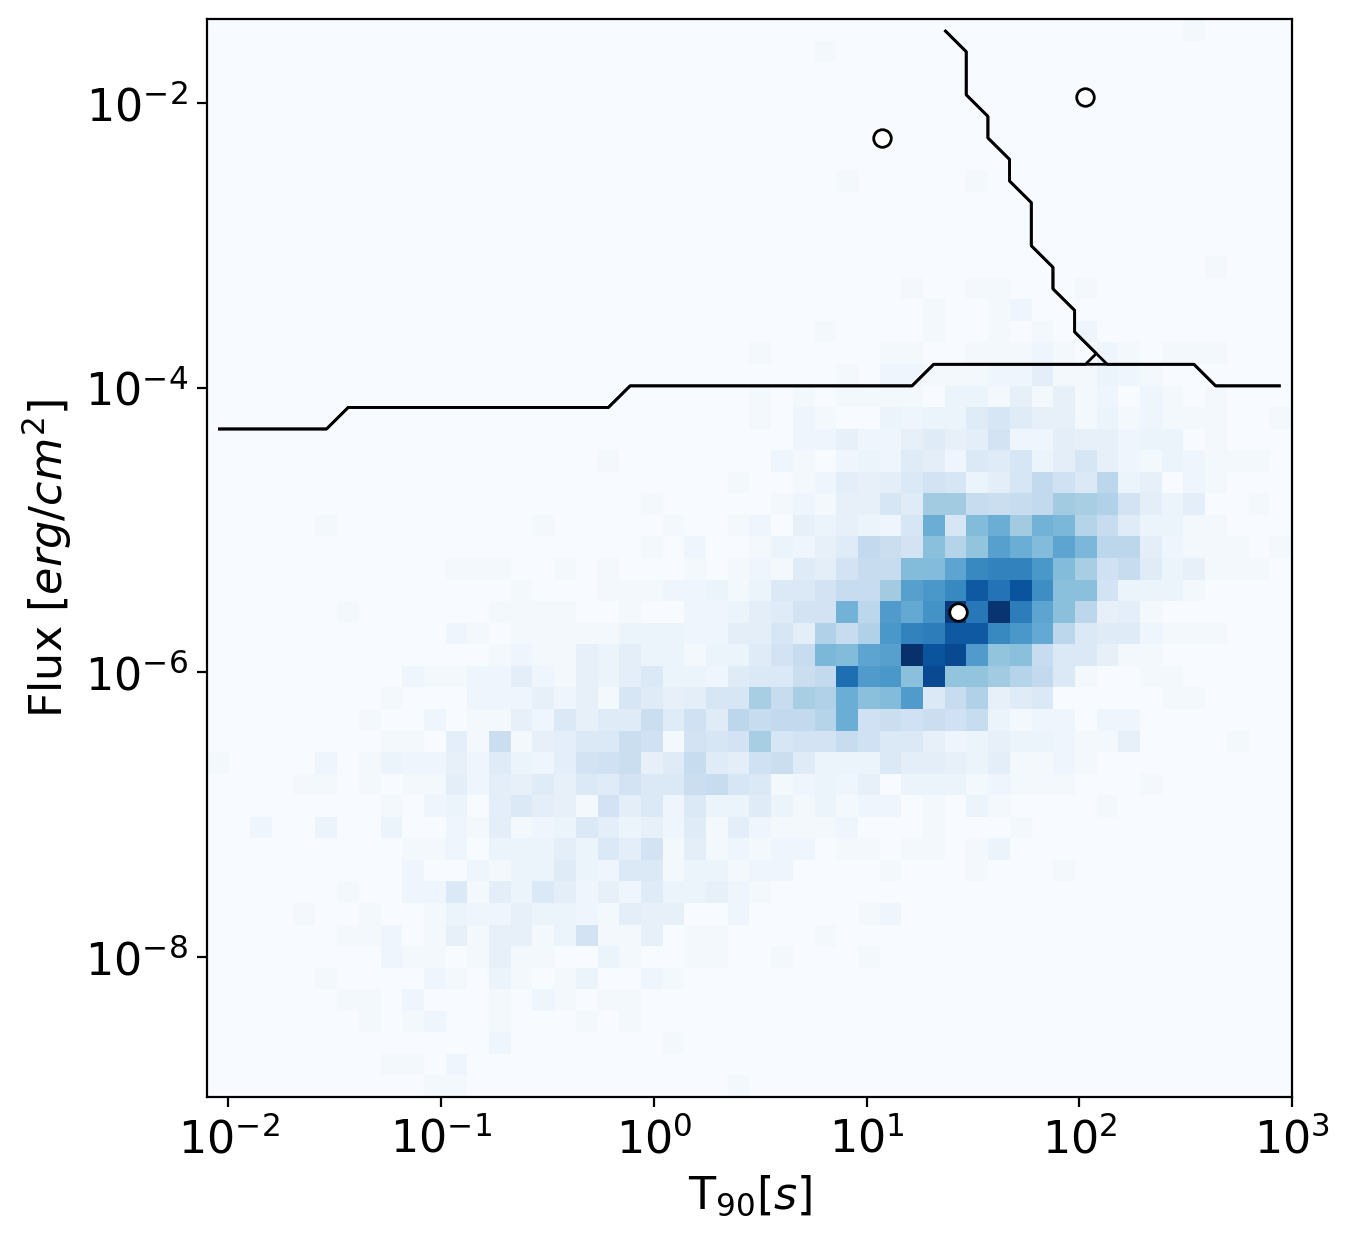

In [32]:
#%matplotlib inline
# Make some plots
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = scaler.inverse_transform(ms.cluster_centers_)
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(scaler.transform(Xgrid)).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()

#### Without scaler
Scaler: Standardize features by removing the mean and scaling to unit variance.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual features do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance).\
For instance many elements used in the objective function of a learning algorithm assume that all features are centered around 0 and have variance in the same order. **If a feature has a variance that is orders of magnitude larger than others, it might dominate the objective function and make the estimator unable to learn from other features correctly as expected**.

In our case the two distribution are very different and we don't want to lose features

In [33]:
bandwidth = estimate_bandwidth(X_train, quantile=0.3) 
#bandwidth = 1.45
bandwidth

2.1152581254610565

In [34]:
ms = MeanShift(bandwidth=bandwidth, bin_seeding=True, cluster_all=True)
ms.fit(X_train)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f178c2930d0>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_modul

MeanShift(bandwidth=2.1152581254610565, bin_seeding=True)

In [35]:
labels_unique = np.unique(ms.labels_)
n_clusters = len(labels_unique[labels_unique >= 0])
print(labels_unique)
print(bandwidth)
print("number of estimated clusters :", n_clusters, ms.cluster_centers_)

[0 1 2]
2.1152581254610565
number of estimated clusters : 3 [[  3.28880216 -12.81423388]
 [  2.46791395  -5.16573228]
 [  5.78637884  -3.24840763]]


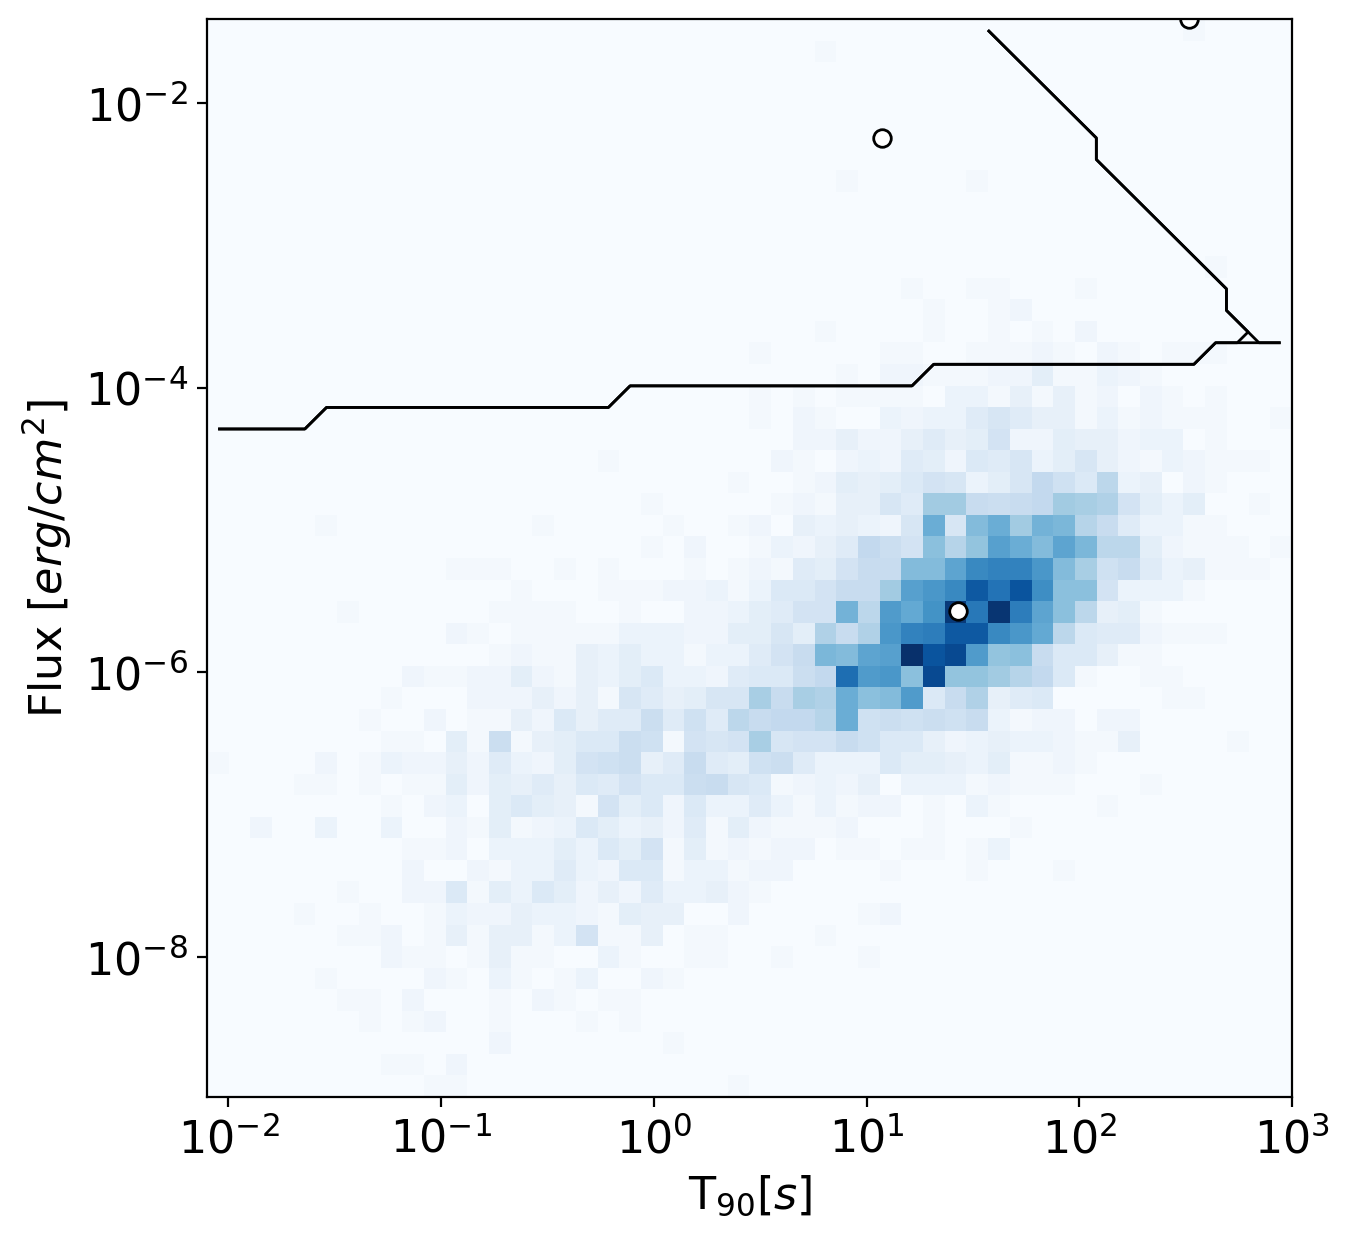

In [36]:
#%matplotlib inline
# Make some plots
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()

/tmp/ipykernel_19681/786259253.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!


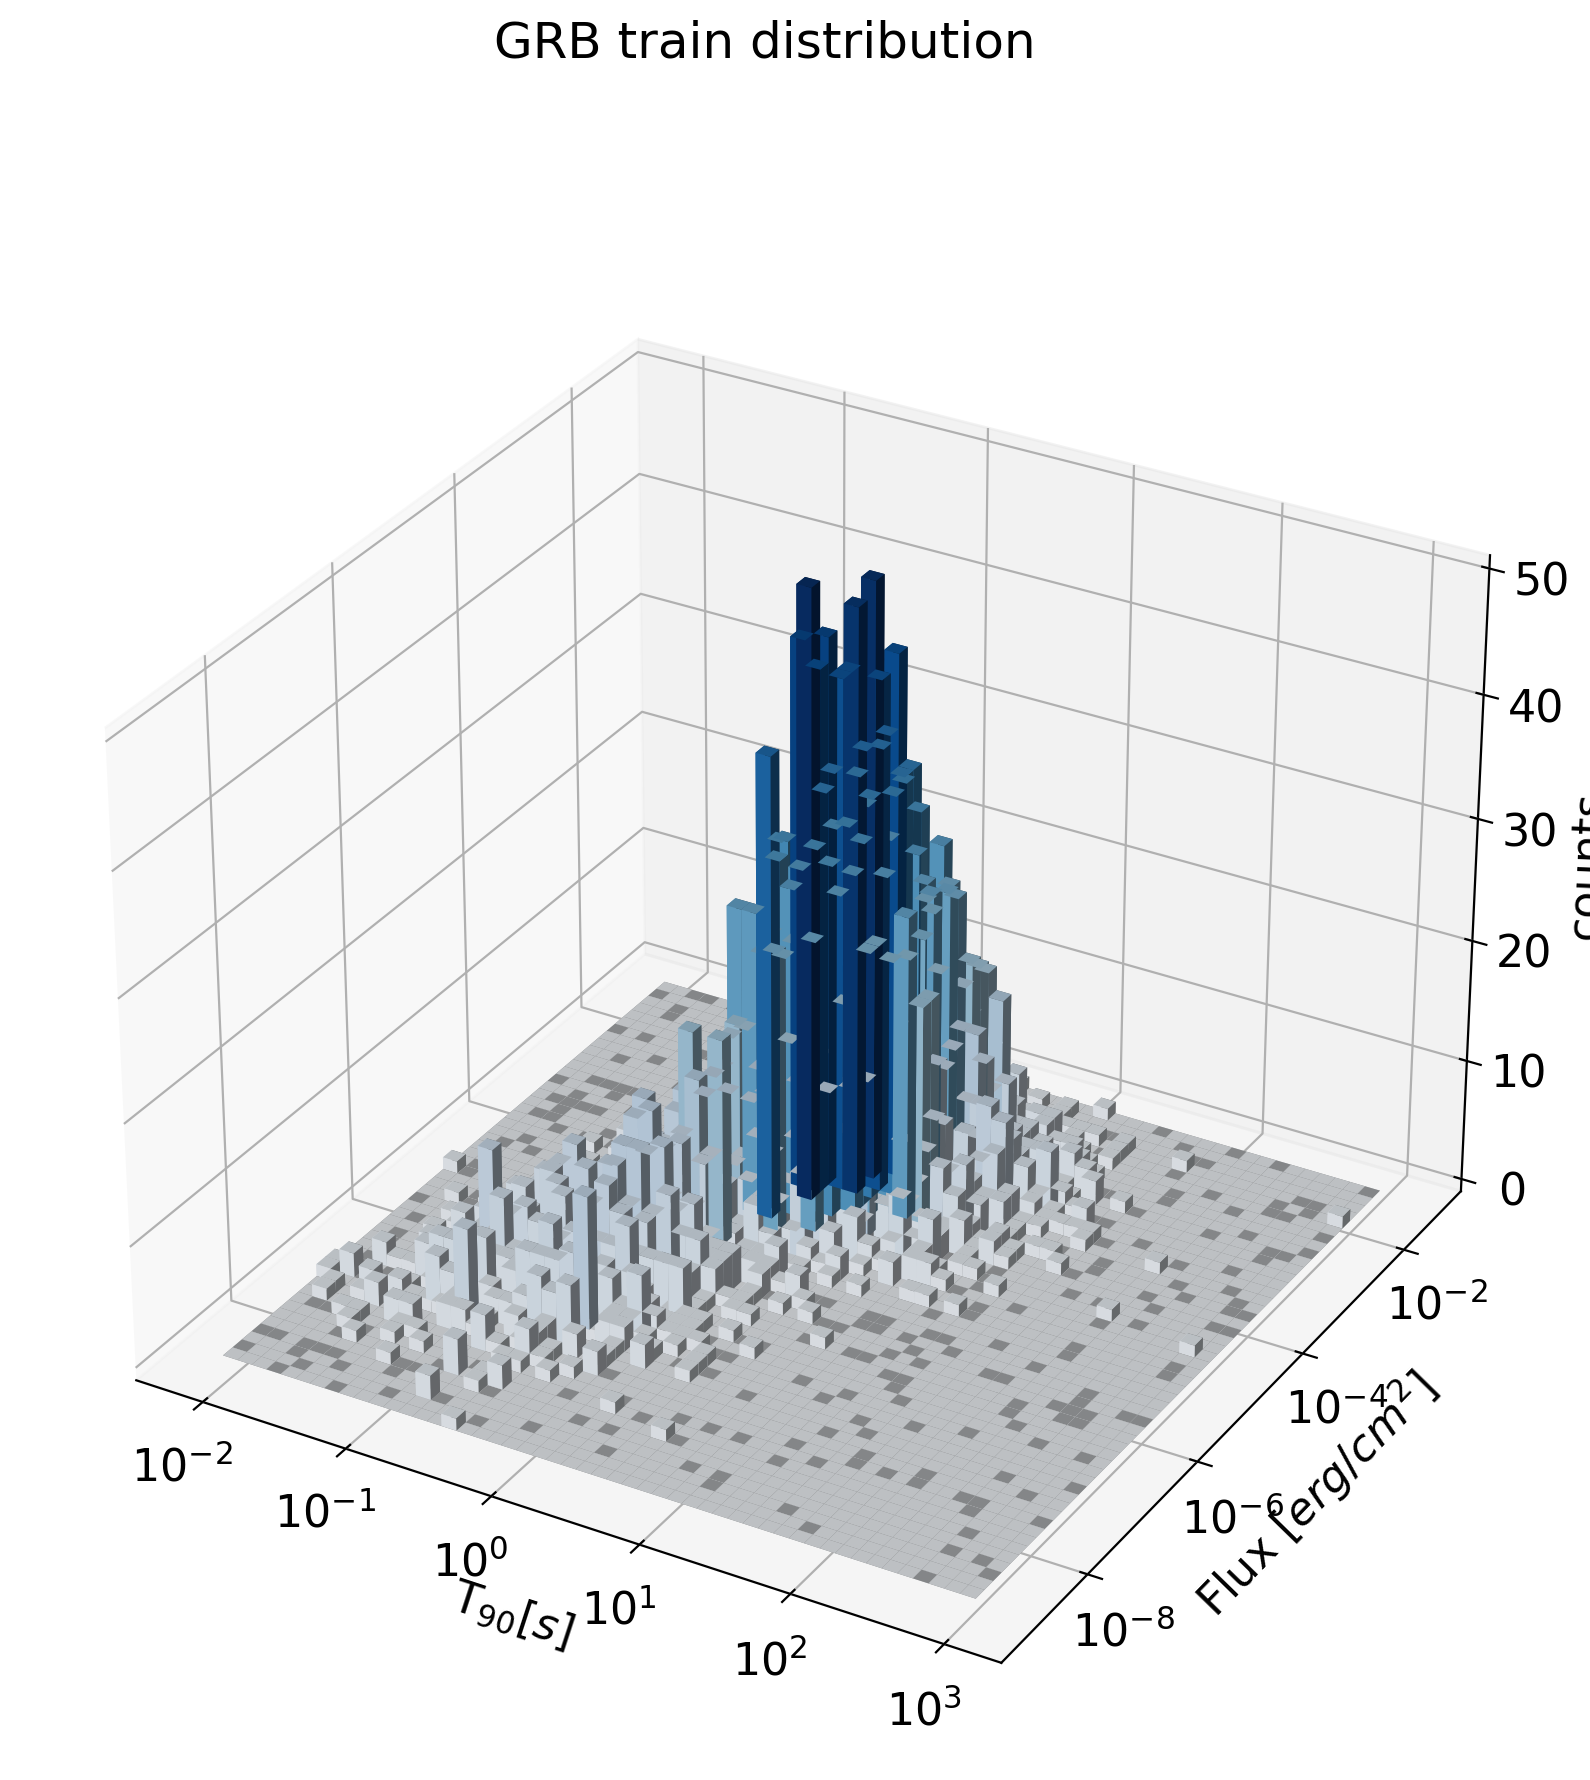

In [37]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,10))
fig.suptitle('GRB train distribution', fontsize=18)

ax = fig.add_subplot(111, projection='3d')


hist, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50) 
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

H = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax.set_xlabel("T$_{90} [s]$")
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

ax.set_zlabel("counts")

#plt.savefig("GRB_trainDistribution")
plt.show()

#### Prediction on test data

In [38]:
cluster_pred = ms.predict(X_test)
print(cluster_pred)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f17a3575700>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[0 0 0 ... 0 0 0]


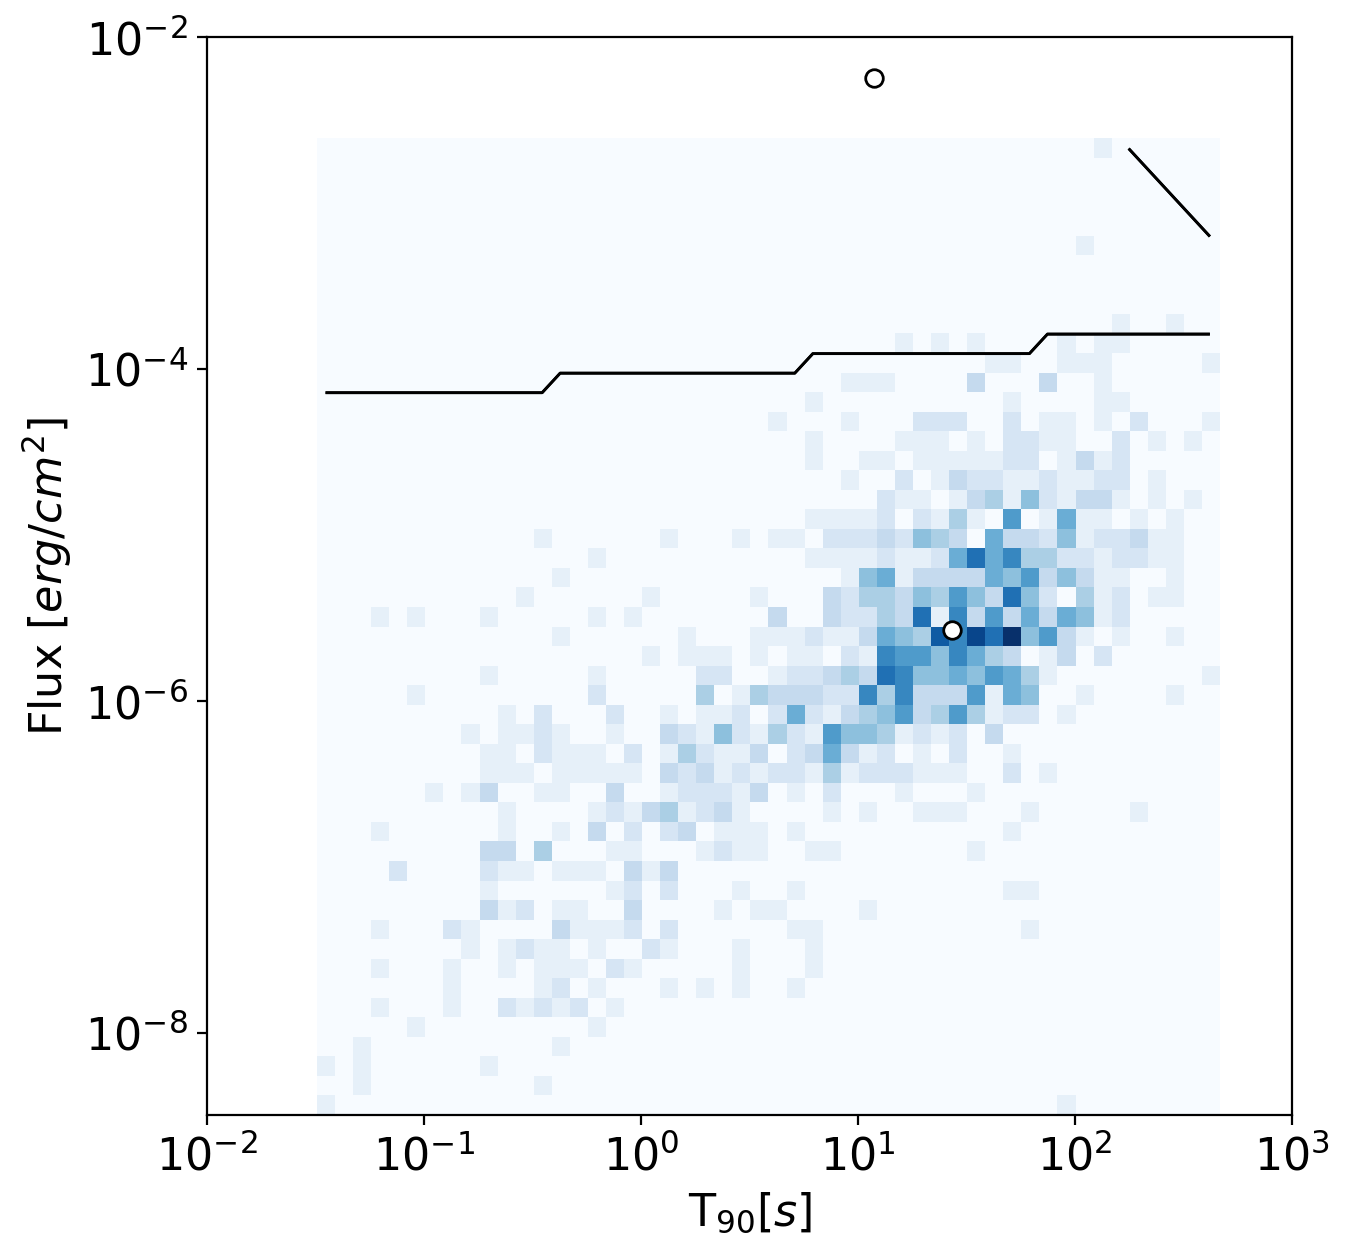

In [39]:
#%matplotlib inline
# Make some plots
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_test[:,0], X_test[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = ms.cluster_centers_
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = ms.predict(Xgrid).reshape((50, 50))

for i in range(n_clusters):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = ms.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$", fontsize=16)
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()

/tmp/ipykernel_19681/1636759363.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!


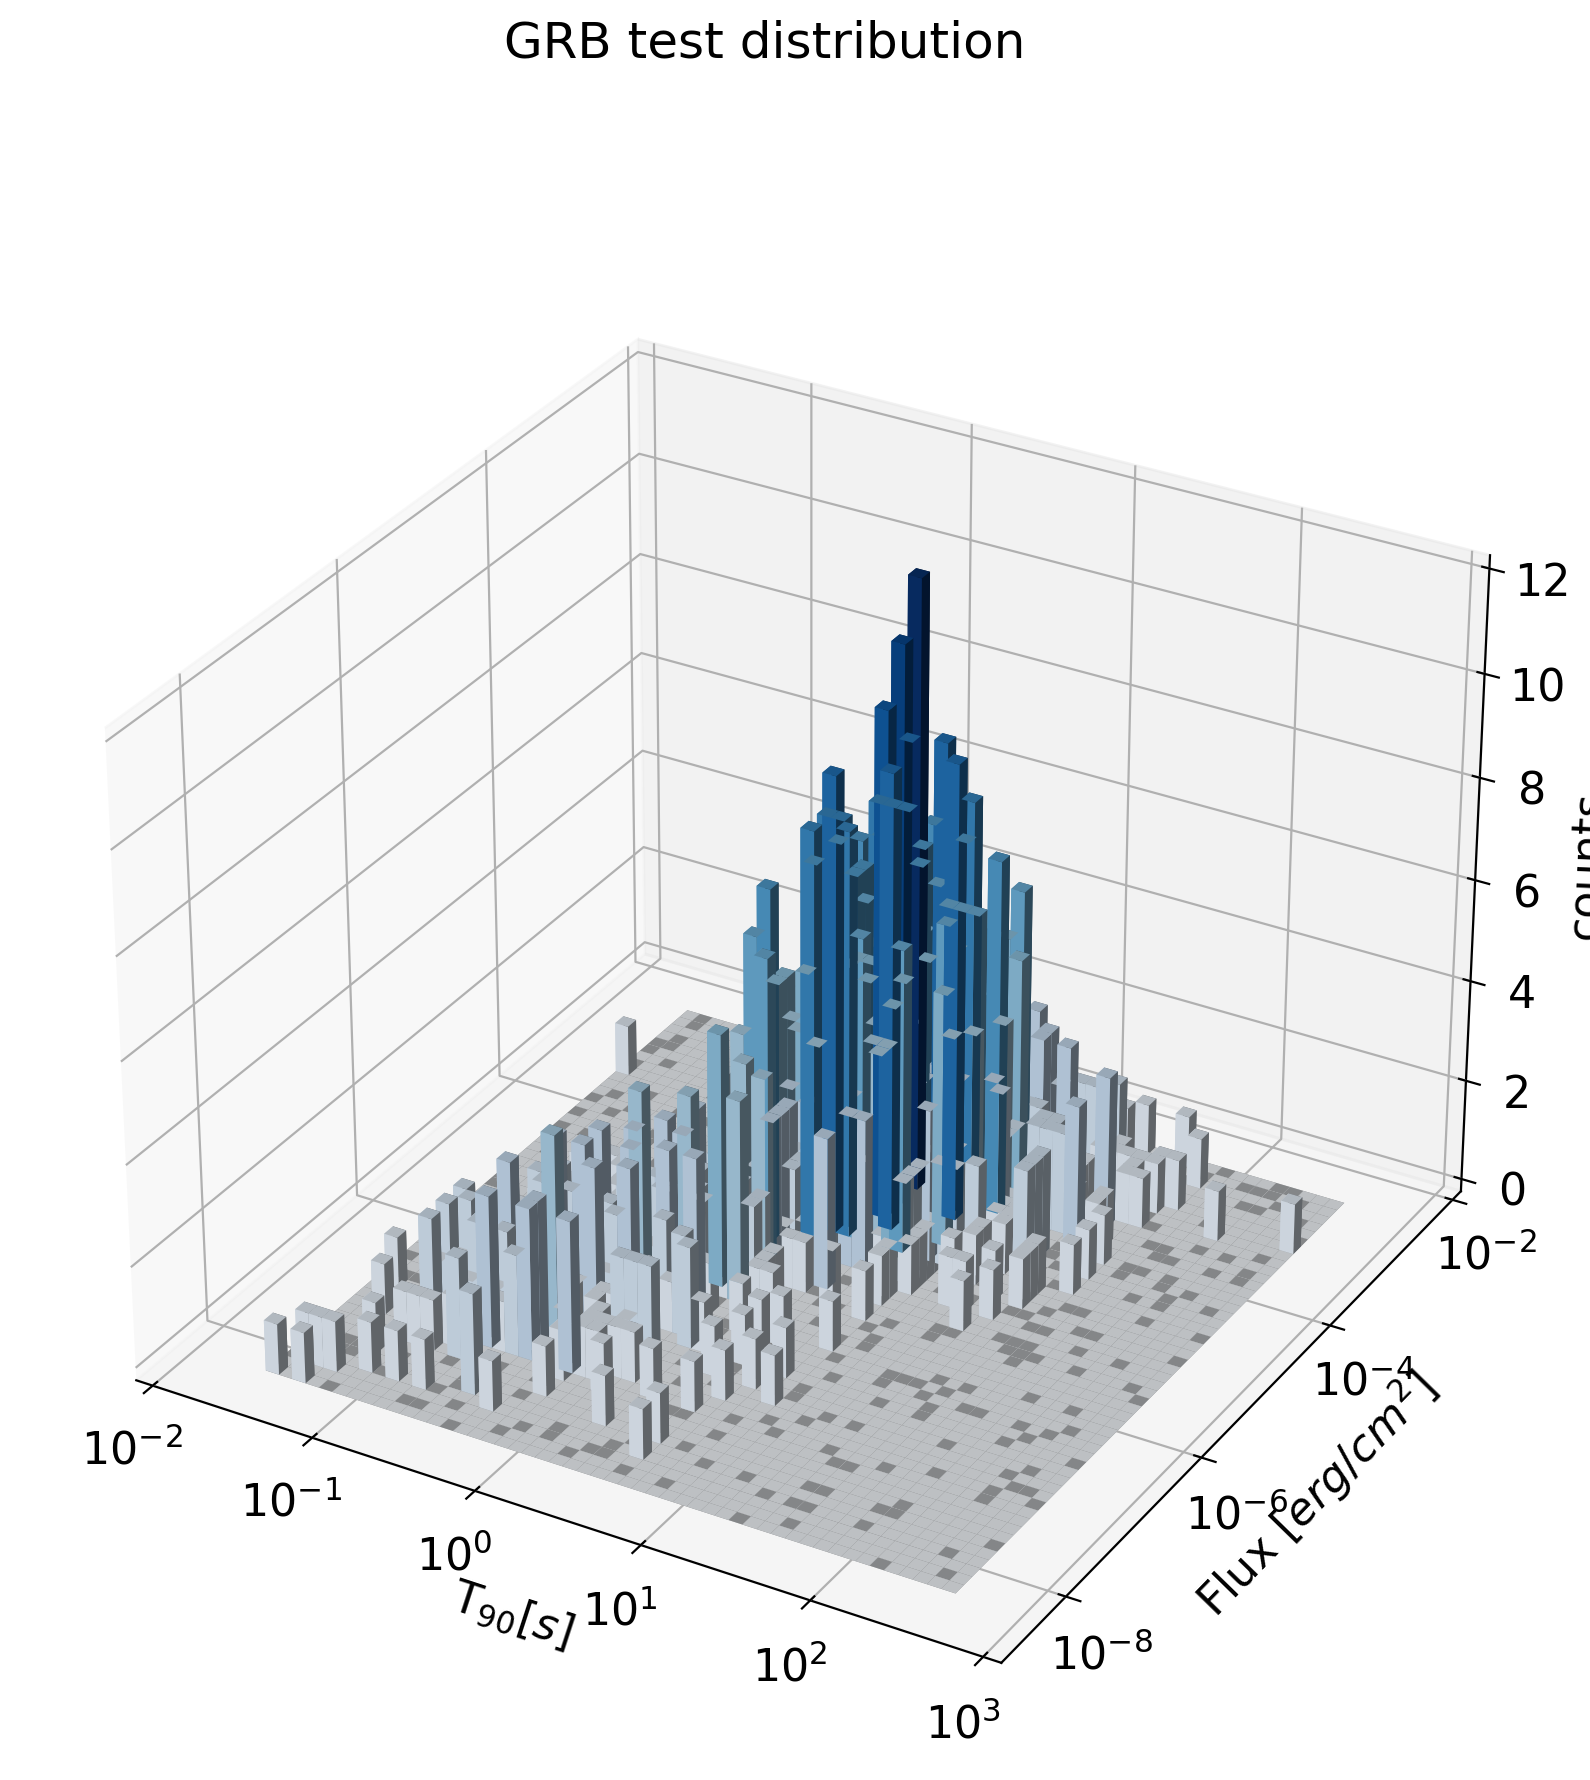

In [40]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,10))
fig.suptitle('GRB test distribution', fontsize=18)

ax = fig.add_subplot(111, projection='3d')


hist, xedges, yedges = np.histogram2d(X_test[:,0], X_test[:,1], 50) 
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

H = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax.set_xlabel("T$_{90} [s]$")
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

ax.set_zlabel("counts")

#plt.savefig("GRB_testDistribution")
plt.show()

### Variational Inference for the Gaussian Mixture Model clustering: unknown number of clusters (OR KNOWN?)
On the sk-learn scheme of clustering VBGMM is in unknown labels but ncomponents must be given.

**Works better than k-Means (known components) but also than Mean-shift (unknown components)!**

In [41]:
# Fit a Dirichlet process Gaussian mixture using n components
n_components=2
dpgmm = BayesianGaussianMixture(n_components=n_components, covariance_type="full")
dpgmm.fit(X_train)
clust_train_pred = dpgmm.predict(X_train)
clus_centers = dpgmm.means_
print(clust_train_pred, "\n", clus_centers)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f178c4889d0>
Traceback (most recent call last):
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/olga/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


[1 1 1 ... 0 0 0] 
 [[  1.21362185 -14.041848  ]
 [  3.46923644 -12.76008082]]


/home/olga/anaconda3/lib/python3.9/site-packages/sklearn/mixture/_base.py:274: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


/tmp/ipykernel_19681/763680225.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('spring', n_components), zorder=1)


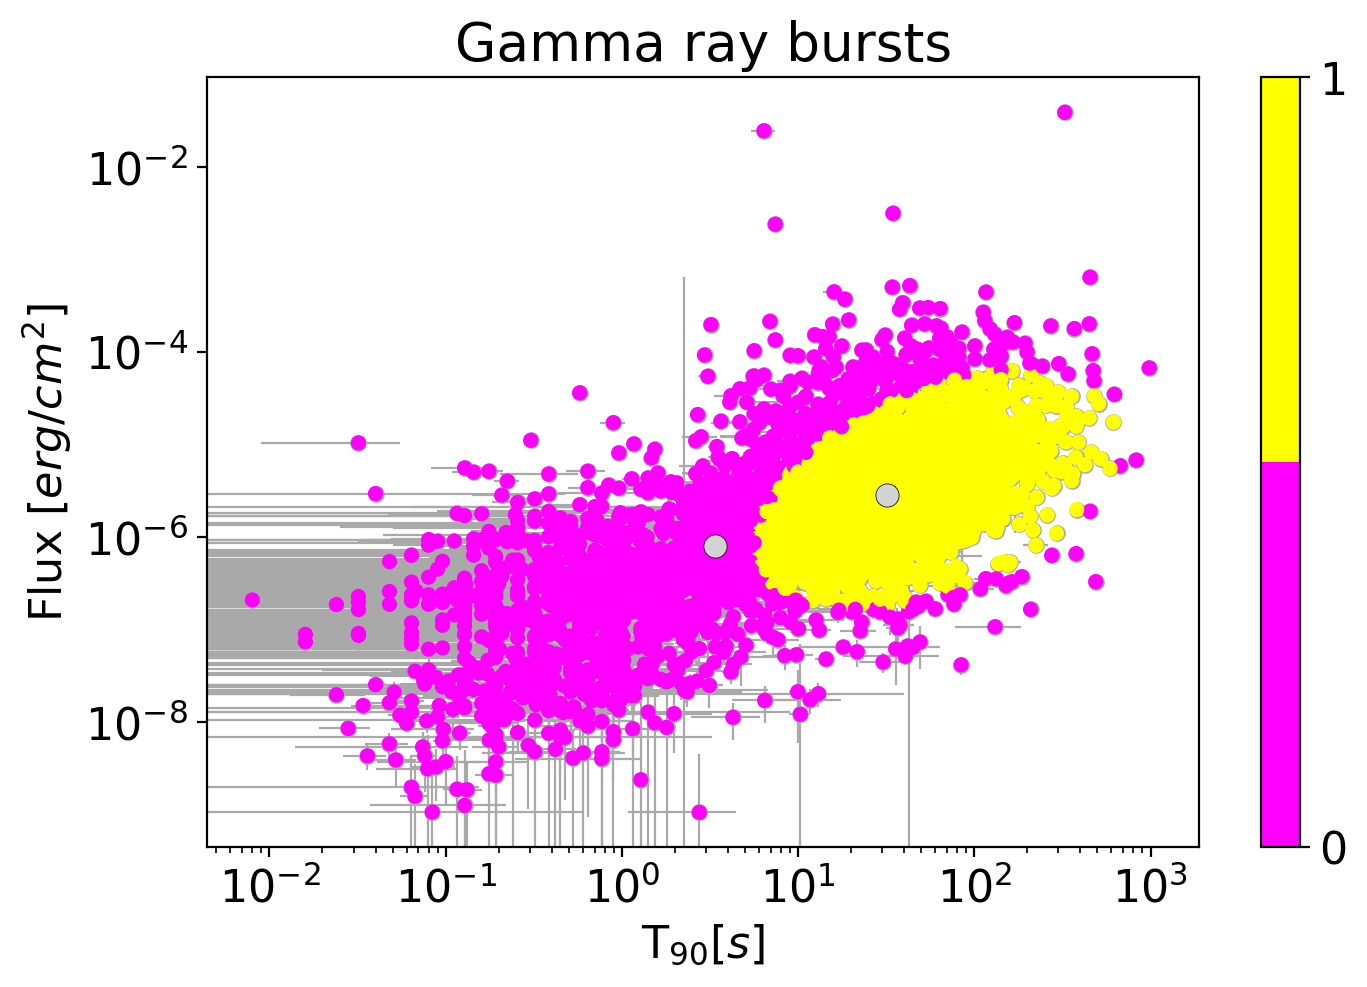

In [42]:
#%matplotlib inline

plt.figure(figsize=(8, 5))
sctt5 = plt.scatter(np.exp(X_train[:, 0]), np.exp(X_train[:, 1]), s=20, c=clust_train_pred, 
                    cmap=plt.cm.get_cmap('spring', n_components), zorder=1)
plt.errorbar(np.exp(X_train[:, 0]),np.exp(X_train[:, 1]), xerr=X_err_train[:, 0],yerr=X_err_train[:, 1], 
             fmt="o", ms=5, mec="darkgray", ecolor='darkgray', mfc="darkgray", elinewidth=0.8, zorder=0)
plt.scatter(np.exp(clus_centers[:,0]), np.exp(clus_centers[:,1]),s=50,c='lightgray', zorder=3)
plt.scatter(np.exp(clus_centers[:,0]), np.exp(clus_centers[:,1]),s=58,c='k', zorder=2)
plt.colorbar(sctt5,ticks=np.arange(n_components))
plt.semilogx()
plt.semilogy()
#plt.legend()
plt.xlabel("T$_{90} [s]$")
plt.ylabel("Flux $[erg/cm^2]$")
plt.title("Gamma ray bursts")
plt.show()

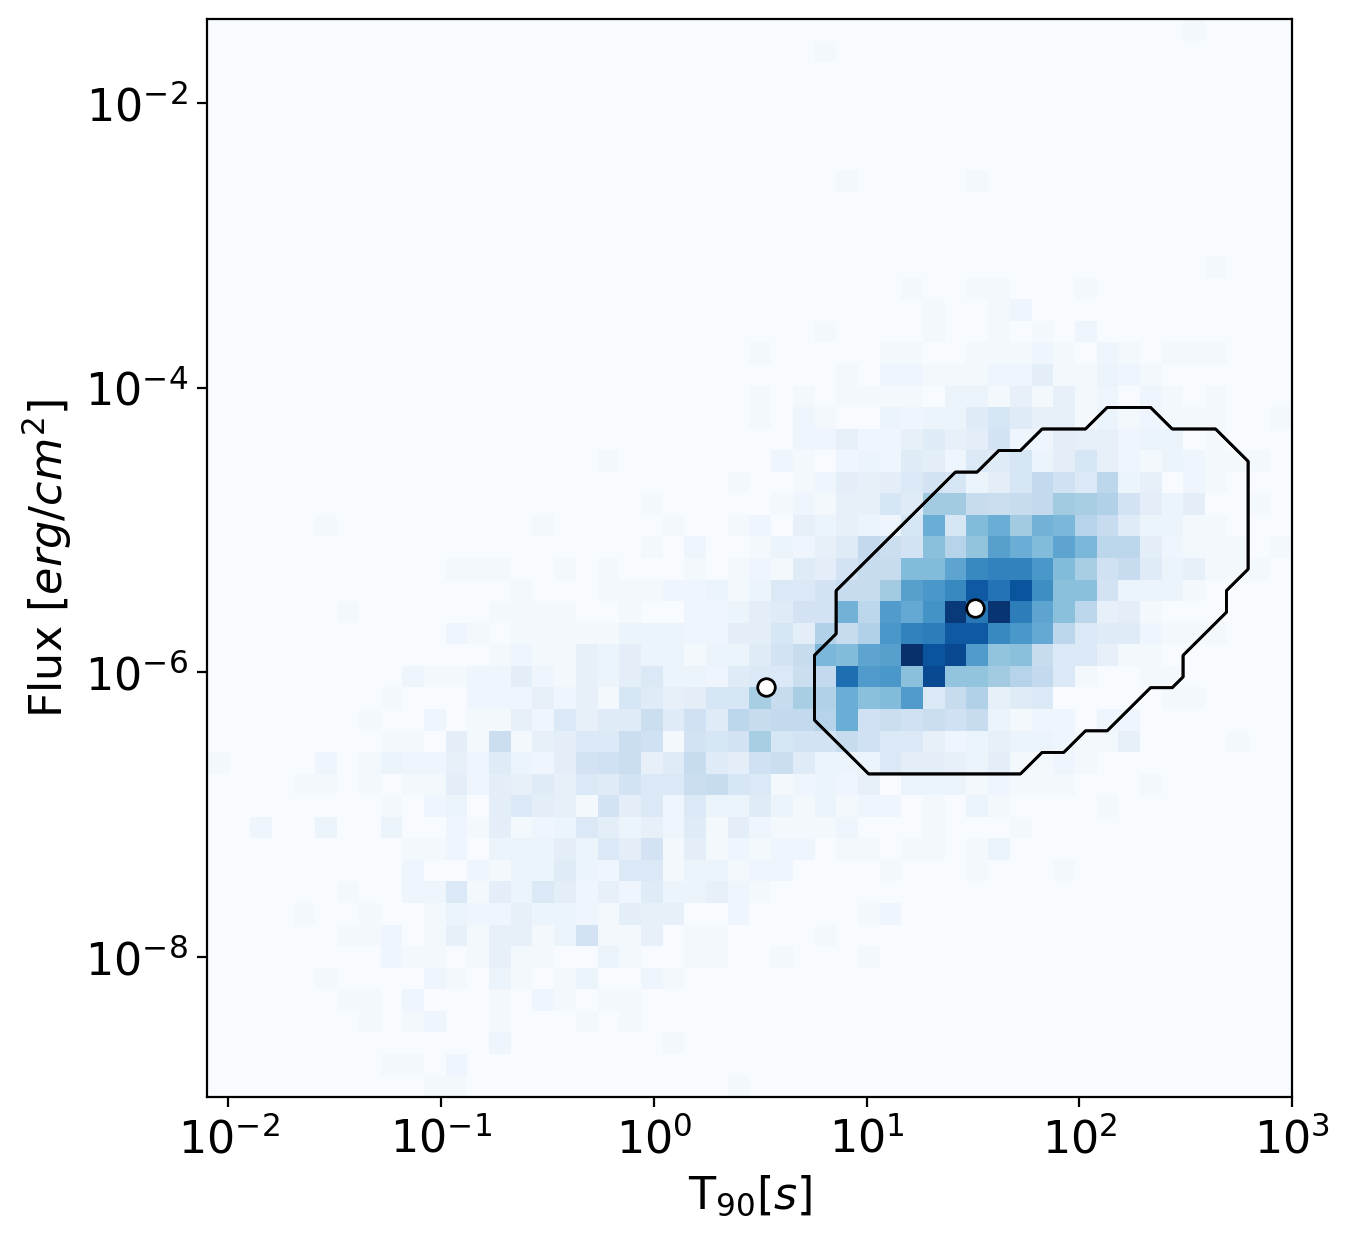

In [43]:
#%matplotlib inline
# Make some plots
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = clus_centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = dpgmm.predict(Xgrid).reshape((50, 50))

for i in range(n_components):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = dpgmm.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()

/tmp/ipykernel_19681/786259253.py:21: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!


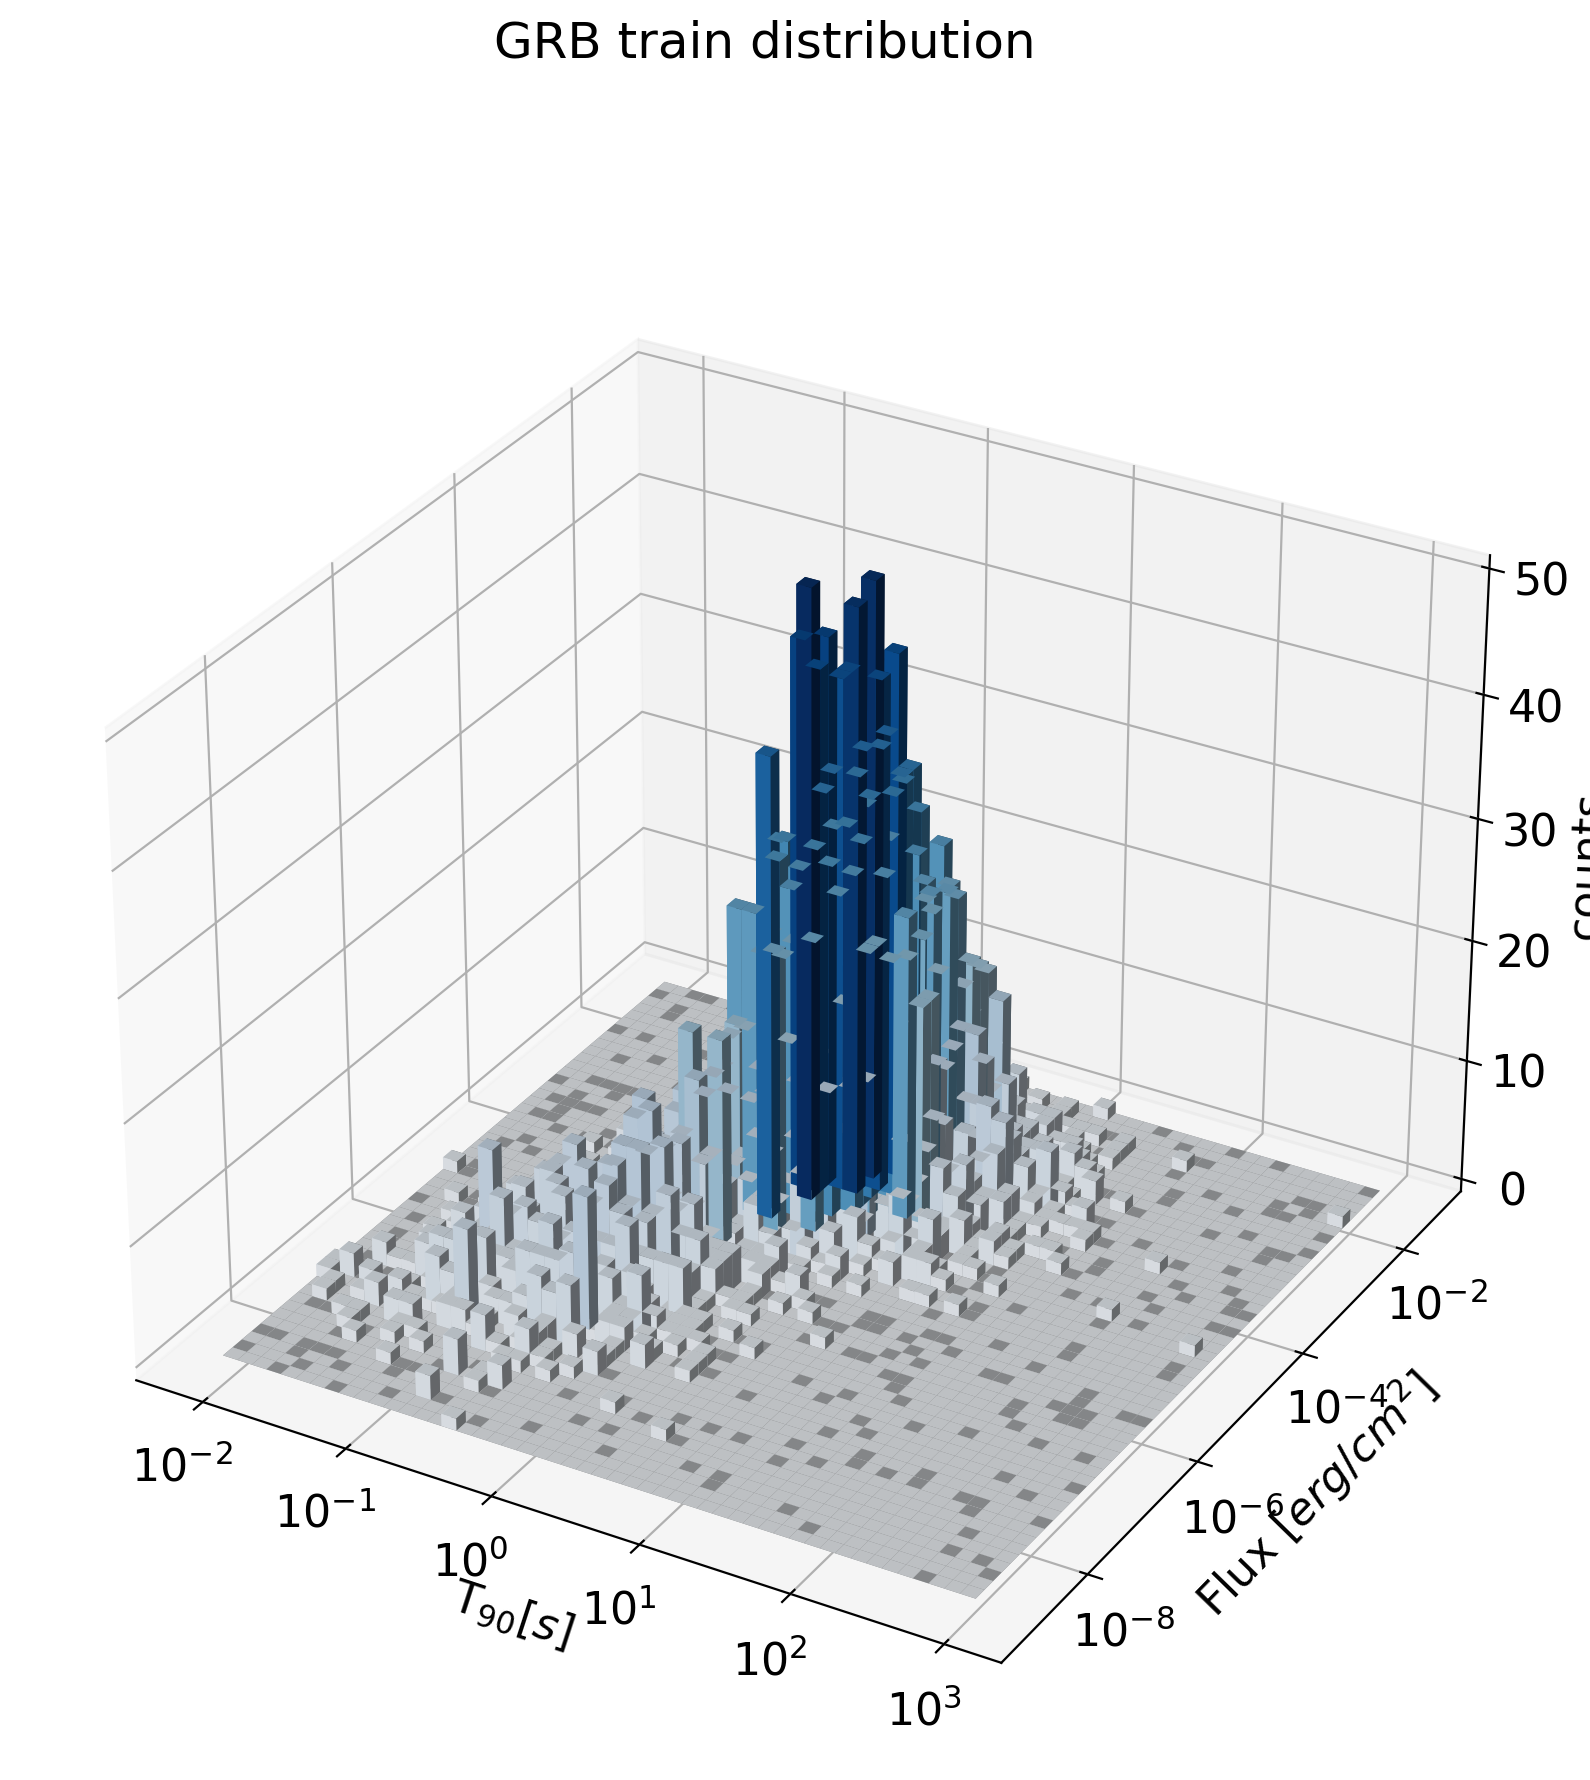

In [44]:
#%matplotlib notebook

fig = plt.figure(figsize=(10,10))
fig.suptitle('GRB train distribution', fontsize=18)

ax = fig.add_subplot(111, projection='3d')


hist, xedges, yedges = np.histogram2d(X_train[:,0], X_train[:,1], 50) 
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:]) -(xedges[1]-xedges[0])


xpos = xpos.flatten()*1./2
ypos = ypos.flatten()*1./2
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = plt.cm.get_cmap('Blues') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

H = ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax.set_xlabel("T$_{90} [s]$")
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

ax.set_zlabel("counts")

#plt.savefig("GRB_trainDistribution")
plt.show()

#### Prediction

In [45]:
clust_test_pred = dpgmm.predict(X_test)
labels_unique = np.unique(clust_test_pred)
n_clusters = len(labels_unique[labels_unique >= 0])

Highlight cluster with group color

/tmp/ipykernel_19681/4073357140.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


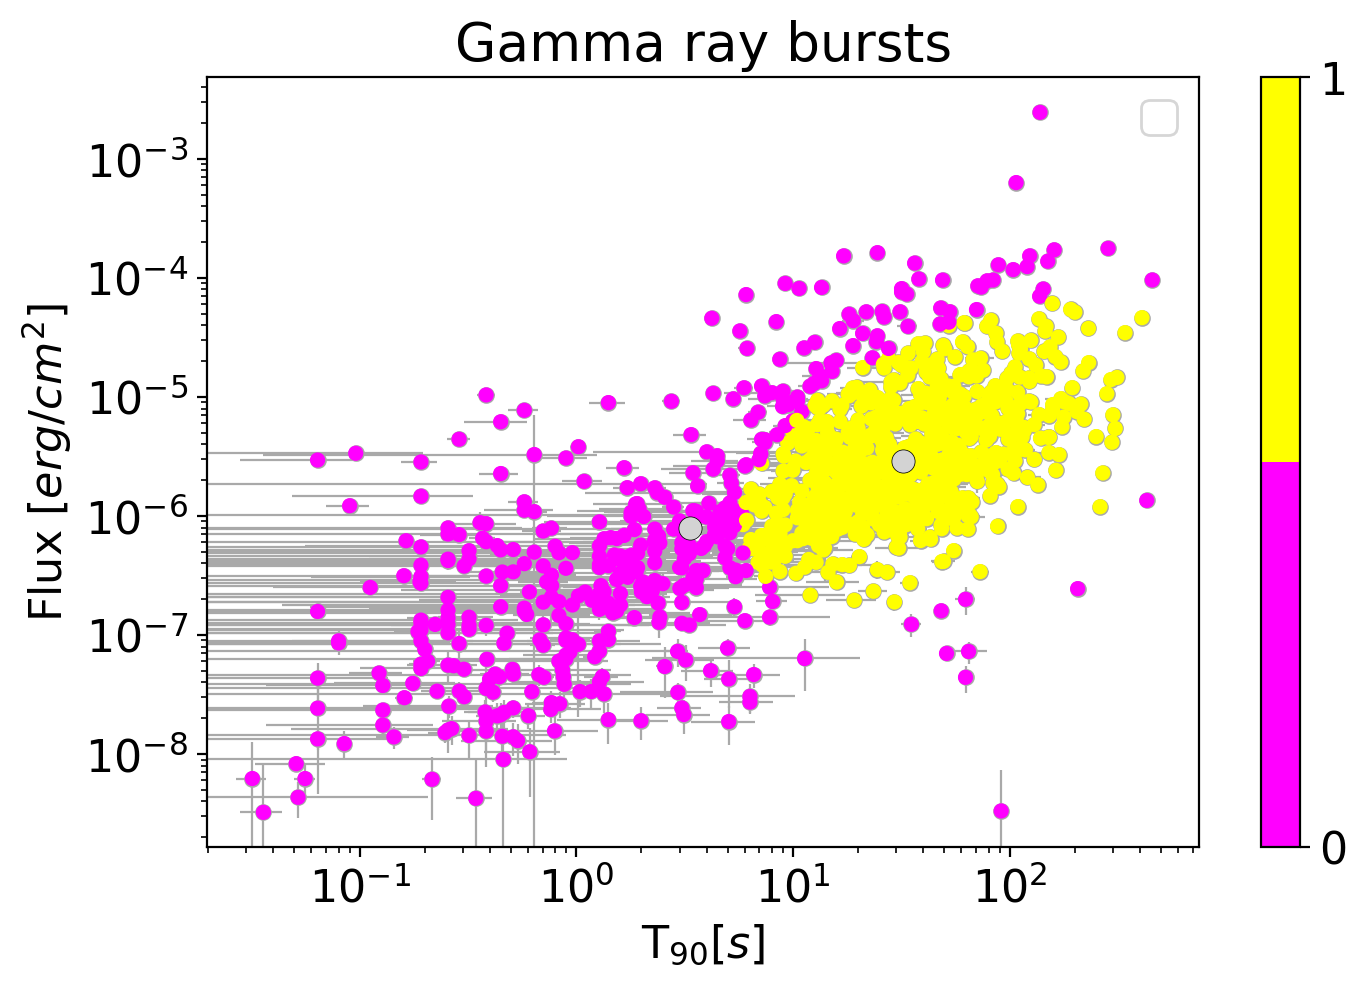

In [48]:
#%matplotlib inline

plt.figure(figsize=(8, 5))
sctt6 = plt.scatter(np.exp(X_test[:, 0]), np.exp(X_test[:, 1]), s=20, c=clust_test_pred, 
                    cmap=plt.cm.get_cmap('spring', n_clusters), zorder=1)
plt.errorbar(np.exp(X_test[:, 0]),np.exp(X_test[:, 1]), xerr=X_err_test[:, 0],yerr=X_err_test[:, 1], 
             fmt="o", ms=5, mec="darkgray", ecolor='darkgray', mfc="darkgray", elinewidth=0.8, zorder=0)
plt.scatter(np.exp(clus_centers[:,0]), np.exp(clus_centers[:,1]),s=50,c='lightgray', zorder=3)
plt.scatter(np.exp(clus_centers[:,0]), np.exp(clus_centers[:,1]),s=58,c='k', zorder=2)
plt.colorbar(sctt6,ticks=np.arange(n_components))
plt.semilogx()
plt.semilogy()
plt.legend()
plt.xlabel("T$_{90} [s]$")
plt.ylabel("Flux $[erg/cm^2]$")
plt.title("Gamma ray bursts")
plt.show()

Highlight cluster with density shadow

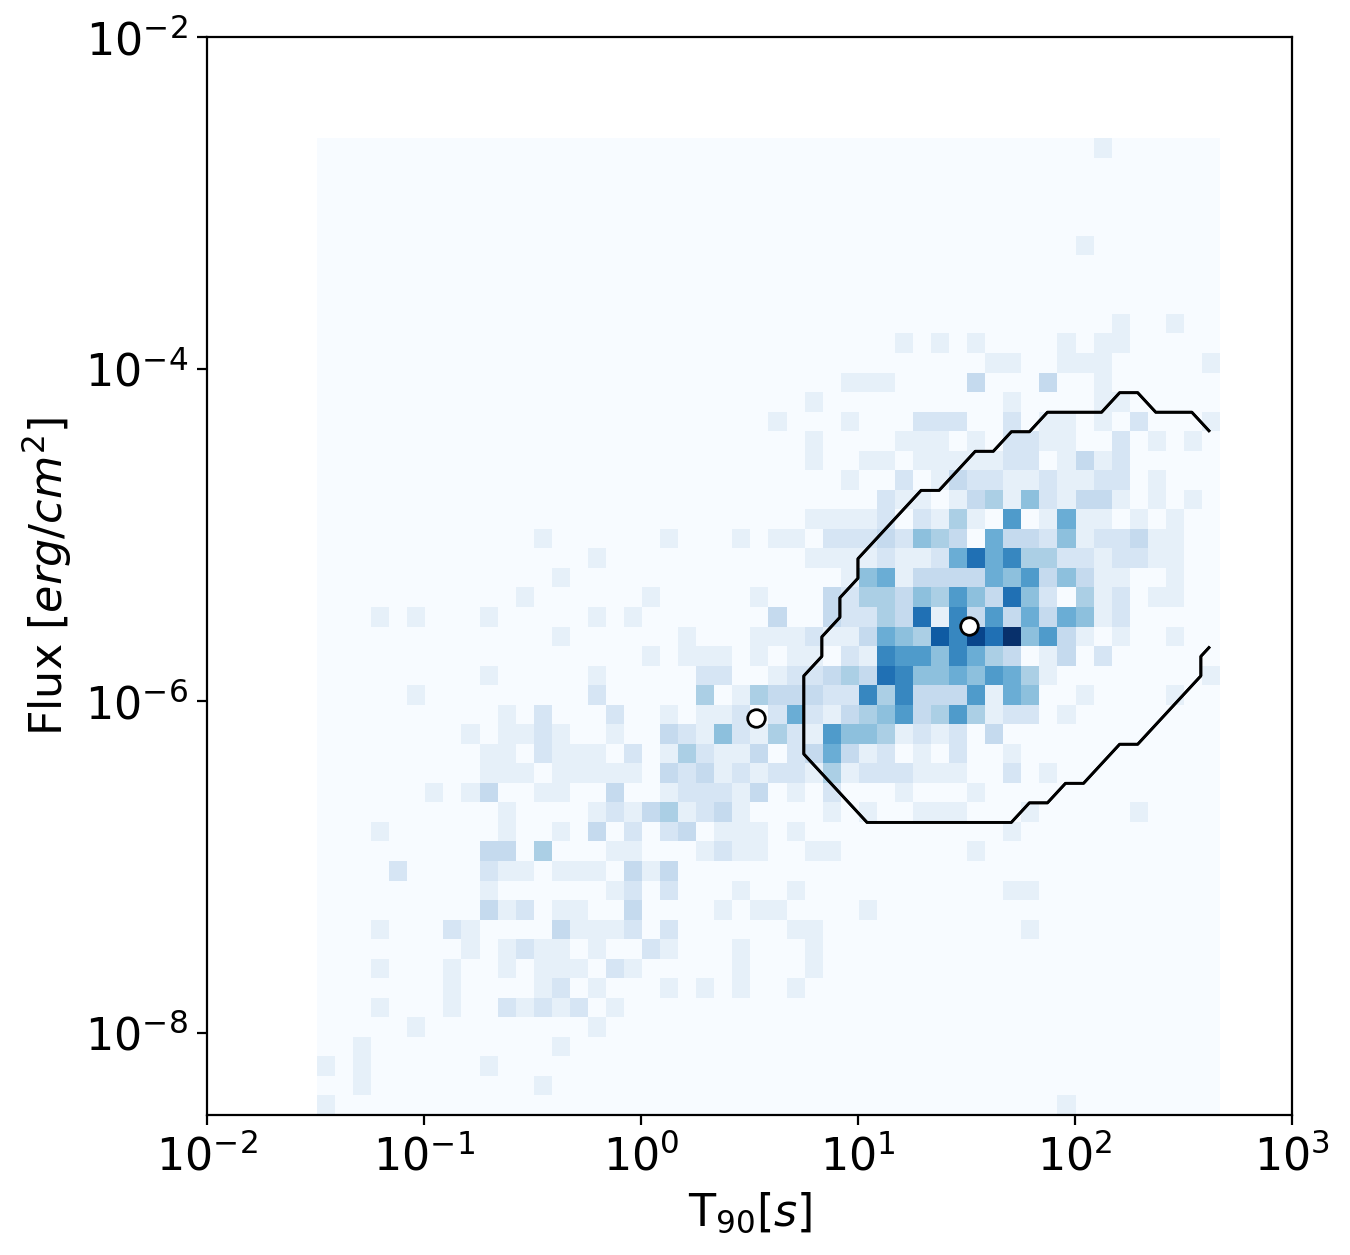

In [47]:
#Cluster with group density 

fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot()

# Compute a 2D histogram  of the input
H, xedges, yedges = np.histogram2d(X_test[:,0], X_test[:,1], 50)

# plot density
ax.imshow(H.T, origin='lower', interpolation='nearest', aspect='auto',
          extent=[xedges[0], xedges[-1],yedges[0], yedges[-1]],cmap='Blues')

# plot cluster centers
cluster_centers = clus_centers
ax.scatter(cluster_centers[:, 0], cluster_centers[:, 1],
           s=40, c='w', edgecolors='k')

# plot cluster boundaries
x_centers = 0.5 * (xedges[1:] + xedges[:-1])
y_centers = 0.5 * (yedges[1:] + yedges[:-1])

Xgrid = np.meshgrid(x_centers, y_centers)
Xgrid = np.array(Xgrid).reshape((2, 50 * 50)).T

H = dpgmm.predict(Xgrid).reshape((50, 50))

for i in range(n_components):
    Hcp = H.copy()
    flag = (Hcp == i)
    Hcp[flag] = 1
    Hcp[~flag] = 0

    ax.contour(x_centers, y_centers, Hcp, [-0.5, 0.5],
               linewidths=1, colors='k')
 
    H = dpgmm.predict(Xgrid).reshape((50, 50))
    
ax.set_xlim(xedges[0], xedges[-1])
ax.set_ylim(yedges[0], yedges[-1])

#ax.set_xscale("log")
#ax.set_yscale("log")
ax.set_xlabel("T$_{90} [s]$", fontsize=16)
ax.set_xticks([-4.6, -2.3, 0, 2.3, 4.6, 6.9])
ax.set_xticklabels(['$10^{-2}$','$10^{-1}$','$10^{0}$','$10^{1}$','$10^{2}$','$10^{3}$'])
ax.set_ylabel("Flux $[erg/cm^2]$")
ax.set_yticks([-18.4,-13.8,-9.2, -4.6])
ax.set_yticklabels(['$10^{-8}$','$10^{-6}$','$10^{-4}$','$10^{-2}$'])

plt.show()